# Classes, planet and spacecraft objects, and finding my initial conditions

C:\Users\Graham\anaconda3\lib\site-packages\matplotlib\quiver.py:651: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\Graham\anaconda3\lib\site-packages\matplotlib\quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


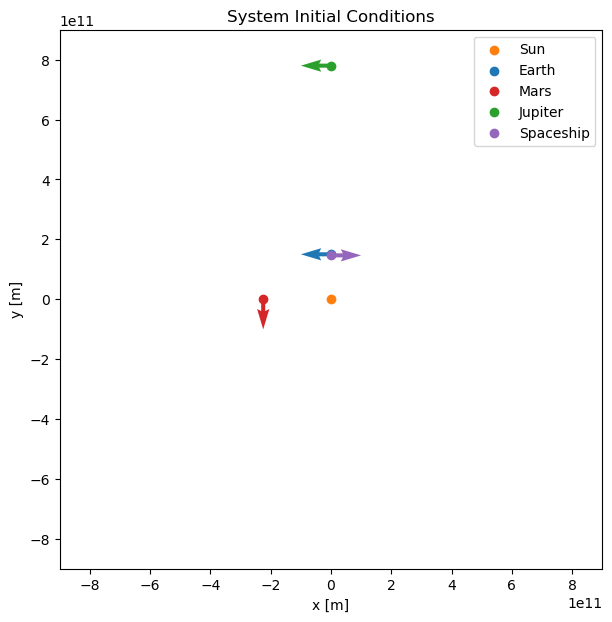

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

class planet:
    
    def __init__(self, name, position, velocity, mass):
        
        '''
        Create an instance of a planet with some initial conditions.
        '''
        
        self.name = name
        
        self.rx = position[0] # m
        self.ry = position[1] # m
        self.rz = 0 # position[2] # m

        self.vx = velocity[0] # m / s
        self.vy = velocity[1] # m / s
        self.vz = 0 # velocity[2] # m / s
        
        self.m = mass # kg
        
        self.px = self.m * self.vx # kg m / s
        self.py = self.m * self.vy # kg m / s
        self.pz = self.m * self.vz # kg m / s
        
        # Calculated values
        self.m_inv = 1 / self.m
        
        self.sphere_of_influence = np.power(self.rx ** 2 + self.ry ** 2 , 0.5) * np.power(self.m / 2e30, 0.4)
        
        # Leave space for future solutions
        self.sol_rx = np.array([])
        self.sol_ry = np.array([])
        self.sol_rz = np.array([])
        
        self.sol_px = np.array([])
        self.sol_py = np.array([])
        self.sol_pz = np.array([])
        
class spaceship:
    
    def __init__(self, name, position, velocity, rocket_params):
        
        '''
        Create an instance of a spaceship with some initial conditions.
        '''
        
        self.name = name
        
        self.rx = position[0] # m
        self.ry = position[1] # m
        self.rz = 0 # position[2] # m

        self.vx = velocity[0] # m / s
        self.vy = velocity[1] # m / s
        self.vz = 0 # velocity[2] # m / s
        
        self.dry_mass = rocket_params[0] # kg
        self.burn_rate = rocket_params[1] # kg / s of fuel burned
        self.total_mass = rocket_params[2] # kg of fuel initially
        self.fuel_mass = self.total_mass - self.dry_mass
        self.v_exhaust = rocket_params[3] # m / s Exhaust velocity of the gas
        self.burn_time = 0.5 * self.fuel_mass / self.burn_rate
        self.burn_angle = np.pi * rocket_params[4] / 180
        self.burn_percent = self.burn_time * rocket_params[5]
        
        self.m = self.dry_mass + self.fuel_mass
        self.m_inv = 1 / self.m
        
        self.px = self.m * self.vx # kg m / s
        self.py = self.m * self.vy # kg m / s
        self.pz = self.m * self.vz # kg m / s
        
        # Leave space for future solutions
        self.sol_rx = np.array([])
        self.sol_ry = np.array([])
        self.sol_rz = np.array([])
        
        self.sol_px = np.array([])
        self.sol_py = np.array([])
        self.sol_pz = np.array([])
        
Sun     = planet(name = 'Sun',     position = [0, 0, 0],             velocity = [0, 0, 0],        mass = 2e30)
Earth   = planet(name = 'Earth',   position = [0,1.5e11, 0],         velocity = [-29.78e3, 0, 0], mass = 6e24)
Mars    = planet(name = 'Mars',    position = [-1.5 * 1.5e11, 0, 0], velocity = [0, -24e3, 0],    mass = 6e23)
Jupiter = planet(name = 'Jupiter', position = [0, 5.2 * 1.5e11, 0],  velocity = [-13e3, 0, 0],    mass = 2e27)

rocket_params = [1e3, 1e3, 6e5, 3e3, 10, 1] # dry mass, burn rate, total mass, v_exh, burn angle, percent of fuel on start
Spaceship = spaceship(name = 'Spaceship', position = [0, 1.5e11 - 3562000000, 0], velocity = [(30510), 0 , 0], rocket_params = rocket_params)

objects = [Sun, Earth, Mars, Jupiter, Spaceship]
        
def plot_objects(objects):
    
    '''
    Plot intitial conditions of all defined objects with initial positions and velocity directions labeled. 
    '''
    
    plt.figure(figsize=(7,7))
    
    colors = ['tab:orange','tab:blue','tab:red','tab:green','tab:purple','tab:pink','tab:olive','tab:cyan']
    
    for i in range(len(objects)):
        
        plt.scatter(objects[i].rx, objects[i].ry, label=objects[i].name, c = colors[i])
        plt.quiver(objects[i].rx, objects[i].ry, objects[i].vx, objects[i].vy, color = colors[i])
    
    plt.xlim(-6*1.5e11, 6*1.5e11)
    plt.ylim(-6*1.5e11, 6*1.5e11)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.legend()
    plt.title('System Initial Conditions')
    plt.show()
    
    return
    
plot_objects(objects)
    

Well this first implementation of initial conditions looks good! However, I am not convinced that this iteration of initial conditions is great. Let's examine what the system looks like now and see if there are any better options.

# Finding the best initial conditions

All the functions here are best described in the `Tests.ipynb` and `Function_Scripts.ipynb`. Please refer there if there are any questions. Anything I write here is going to be using that material to arrive at the best initial conditions. 

I want a stable orbit for the spacecraft around Earth where it stays at a relatively constant distance for about a year. it is important to find this good orbit before I implement the actual rocketry part. I will take an initial guess and then check values around that guess to see which results in the most constant distance from Earth.

In [2]:
########################################################################
# Redefining the objects and choosing which ones I want in my simulation
########################################################################

Sun     = planet(name = 'Sun',     position = [0, 0, 0],             velocity = [0, 0, 0],        mass = 2e30)
Earth   = planet(name = 'Earth',   position = [0,1.5e11, 0],         velocity = [-29.78e3, 0, 0], mass = 6e24)
Mars    = planet(name = 'Mars',    position = [-1.5 * 1.5e11, 0, 0], velocity = [0, -24e3, 0],    mass = 6e23)
Jupiter = planet(name = 'Jupiter', position = [0, 5.2 * 1.5e11, 0],  velocity = [-13e3, 0, 0],    mass = 2e27)

# No rocket here but I still assign the values.
rocket_params = [1e3, 1e3, 6e5, 3e3, 10, 1] # dry mass, burn rate, total mass, v_exh, burn angle, percent of fuel on start
# Guess a spaceship orbiting at the distance of the moon at the velocity of the moon
Spaceship = spaceship(name = 'Spaceship', position = [0, 1.5e11 + 4e8, 0], velocity = [-(31.5e3), 0 , 0], rocket_params = rocket_params)

# Only grabbbing the objects I want. Jupiter and Mars won't affect this orbit much so I neglect them.
objects = [Sun, Earth, Spaceship]

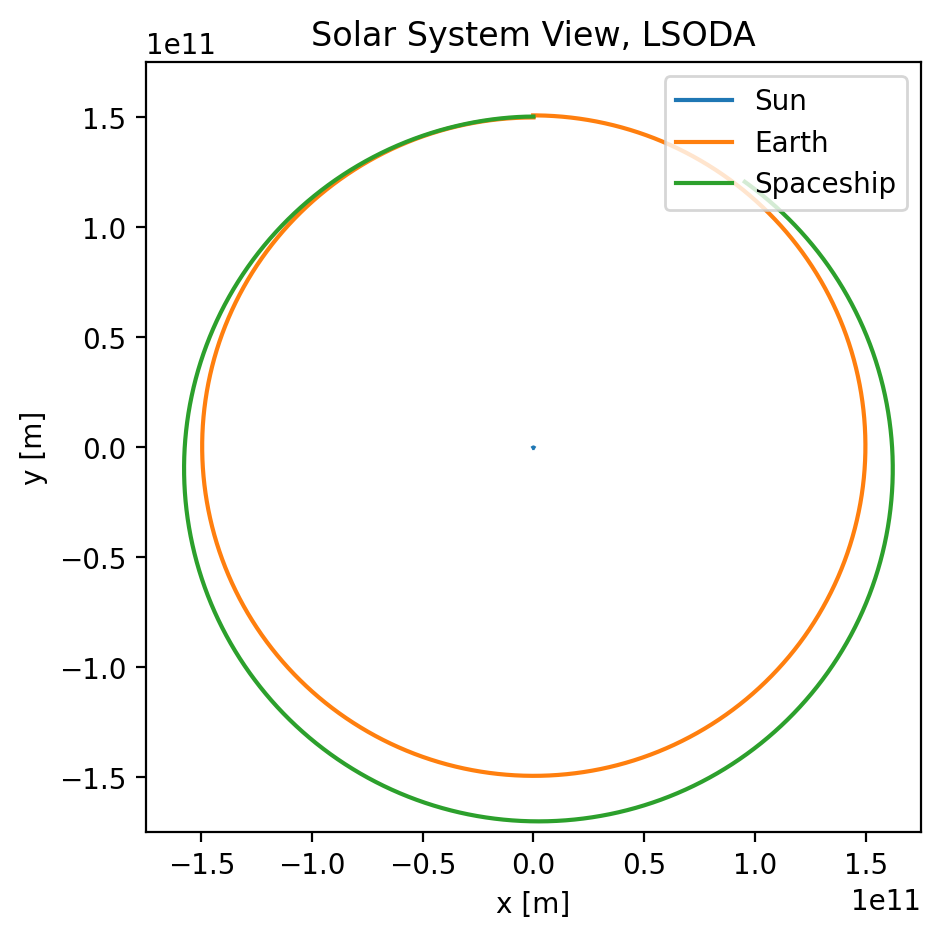

<Figure size 640x480 with 0 Axes>

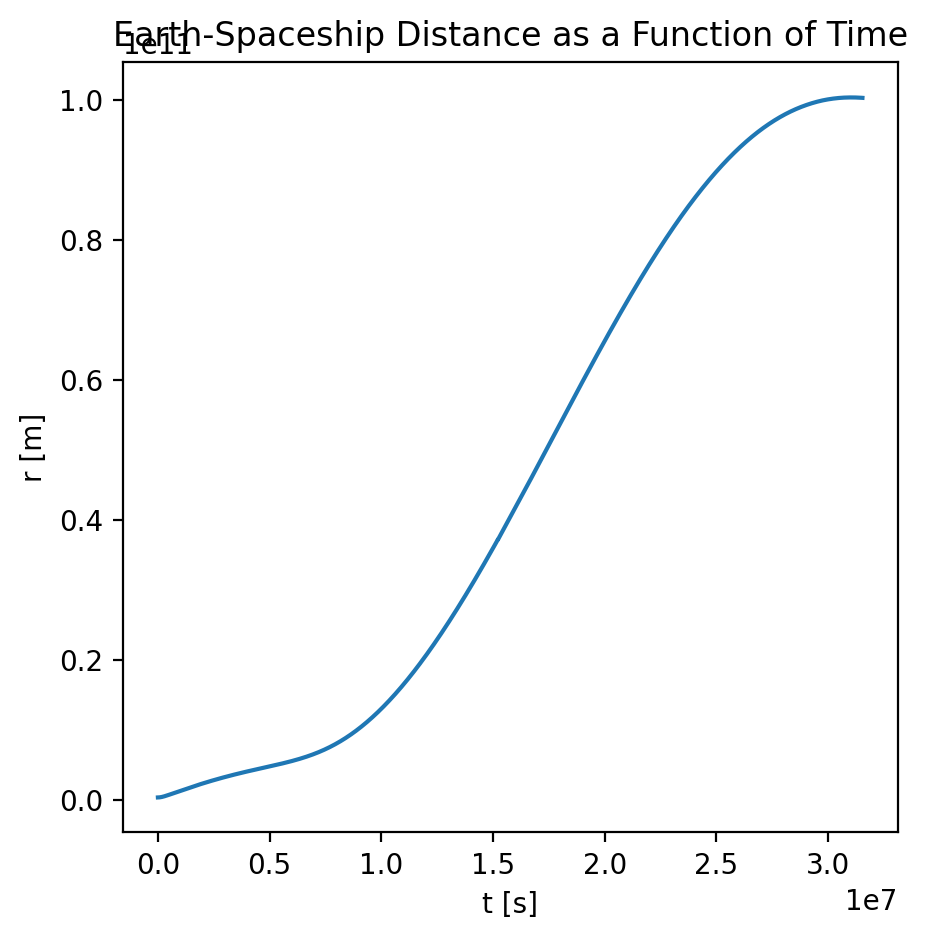

In [3]:
def f(t,y):
    '''This function creates the ODE function for the scipy integrator without rocket burn.'''
    
    G = 6.67e-11
    
    # Defining the masses 
    m = np.array([0])
    for o in range(len(objects)):
        m = np.append(m, objects[o].m)
    
    ###################### 
    # Variable definitions 
    ###################### 
    
    # Sun variable definitions 
    x1 = y[0]
    y1 = y[1]
    z1 = y[2]
    px1 = y[3]
    py1 = y[4]
    pz1 = y[5]    
    
    # Earth variable definitions 
    x2 = y[6]
    y2 = y[7]
    z2 = y[8]
    px2 = y[9]
    py2 = y[10]
    pz2 = y[11]    
    
    # Spaceship variable definitions 
    x3 = y[12]
    y3 = y[13]
    z3 = y[14]
    px3 = y[15]
    py3 = y[16]
    pz3 = y[17]    

    ######################## 
    # Derivative definitions 
    ######################## 
    
    # Sun derivative definitions 
    dx1 = px1 / m[1]
    dy1 = py1 / m[1]
    dz1 = pz1 / m[1]
    dpx1 = -G * m[1] * ( m[2] * (x1 - x2) / (((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) ** (3/2)) + m[3] * (x1 - x3) / (((x1 - x3)**2 + (y1 - y3)**2 + (z1 - z3)**2) ** (3/2)) )
    dpy1 = -G * m[1] * ( m[2] * (y1 - y2) / (((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) ** (3/2)) + m[3] * (y1 - y3) / (((x1 - x3)**2 + (y1 - y3)**2 + (z1 - z3)**2) ** (3/2)) )
    dpz1 = -G * m[1] * ( m[2] * (z1 - z2) / (((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) ** (3/2)) + m[3] * (z1 - z3) / (((x1 - x3)**2 + (y1 - y3)**2 + (z1 - z3)**2) ** (3/2)) )
    
    # Earth derivative definitions 
    dx2 = px2 / m[2]
    dy2 = py2 / m[2]
    dz2 = pz2 / m[2]
    dpx2 = -G * m[2] * ( m[1] * (x2 - x1) / (((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2) ** (3/2)) + m[3] * (x2 - x3) / (((x2 - x3)**2 + (y2 - y3)**2 + (z2 - z3)**2) ** (3/2)) )
    dpy2 = -G * m[2] * ( m[1] * (y2 - y1) / (((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2) ** (3/2)) + m[3] * (y2 - y3) / (((x2 - x3)**2 + (y2 - y3)**2 + (z2 - z3)**2) ** (3/2)) )
    dpz2 = -G * m[2] * ( m[1] * (z2 - z1) / (((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2) ** (3/2)) + m[3] * (z2 - z3) / (((x2 - x3)**2 + (y2 - y3)**2 + (z2 - z3)**2) ** (3/2)) )
    
    # Spaceship derivative definitions 
    dx3 = px3 / m[3]
    dy3 = py3 / m[3]
    dz3 = pz3 / m[3]
    dpx3 = -G * m[3] * ( m[1] * (x3 - x1) / (((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2) ** (3/2)) + m[2] * (x3 - x2) / (((x3 - x2)**2 + (y3 - y2)**2 + (z3 - z2)**2) ** (3/2)) )
    dpy3 = -G * m[3] * ( m[1] * (y3 - y1) / (((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2) ** (3/2)) + m[2] * (y3 - y2) / (((x3 - x2)**2 + (y3 - y2)**2 + (z3 - z2)**2) ** (3/2)) )
    dpz3 = -G * m[3] * ( m[1] * (z3 - z1) / (((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2) ** (3/2)) + m[2] * (z3 - z2) / (((x3 - x2)**2 + (y3 - y2)**2 + (z3 - z2)**2) ** (3/2)) )
        
    return np.array([dx1, dy1, dz1, dpx1, dpy1, dpz1, dx2, dy2, dz2, dpx2, dpy2, dpz2, dx3, dy3, dz3, dpx3, dpy3, dpz3])

# Defining in initial conditions
y0 = np.array([0, 0, 0, 0.0, 0.0, 0.0, 0, 150000000000.0, 0, -1.7868e+29, 0.0, 0.0, 0, 150400000000.0, 0, -18900000000.0, 0.0, 0.0])
t_span = [0,31540000.0]
t_eval = np.linspace(0, 31540000.0, 1000000)

# Running the ODE solver
sol = solve_ivp(f, t_span, y0, method='LSODA', t_eval=t_eval, min_step=1)

# Assigning solutions for Sun
objects[0].sol_rx = sol.y[0]
objects[0].sol_ry = sol.y[1]
objects[0].sol_rz = sol.y[2]
objects[0].sol_px = sol.y[3]
objects[0].sol_py = sol.y[4]
objects[0].sol_pz = sol.y[5]
objects[0].sol_t = sol.t

# Assigning solutions for Earth
objects[1].sol_rx = sol.y[6]
objects[1].sol_ry = sol.y[7]
objects[1].sol_rz = sol.y[8]
objects[1].sol_px = sol.y[9]
objects[1].sol_py = sol.y[10]
objects[1].sol_pz = sol.y[11]
objects[1].sol_t = sol.t

# Assigning solutions for Spaceship
objects[2].sol_rx = sol.y[12]
objects[2].sol_ry = sol.y[13]
objects[2].sol_rz = sol.y[14]
objects[2].sol_px = sol.y[15]
objects[2].sol_py = sol.y[16]
objects[2].sol_pz = sol.y[17]
objects[2].sol_t = sol.t

############
# Some plots
############

# Plot Solar System View
plt.figure(figsize=(5,5), dpi=200)
plt.plot(Sun.sol_rx, Sun.sol_ry, label='Sun')
plt.plot(Earth.sol_rx, Earth.sol_ry, label='Earth')
plt.plot(Spaceship.sol_rx, Spaceship.sol_ry, label='Spaceship')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.xlim(-1.75e11, 1.75e11)
plt.ylim(-1.75e11, 1.75e11)
plt.title('Solar System View, LSODA')
plt.show()

# Plot Distance of the Spaceship from Earth.
plt.figure()
plt.figure(figsize=(5,5), dpi=200)
plt.plot(Spaceship.sol_t, ((Spaceship.sol_ry-Earth.sol_ry)**2 + (Spaceship.sol_rx-Earth.sol_rx)**2)**(1/2))
plt.xlabel('t [s]')
plt.ylabel('r [m]')
plt.title('Earth-Spaceship Distance as a Function of Time')
plt.show()


This looks like it was not the best guess. No worries, lets have the computer test a bunch of values and see if one converges!

I am going to minimize:
$$\left|\left|\left(|\vec{R_{Moon}} - \vec{R_{Earth}}| - |\vec{R_{Moon,i}} - \vec{R_{Earth,i}|}\right)^2\right|\right|$$ 

Because of how I wrote the code, I need to edit the initial conditions my script wrote for me instead of the object itself. This makes it more challenging but there is no easy way around it if I want to use this solver.

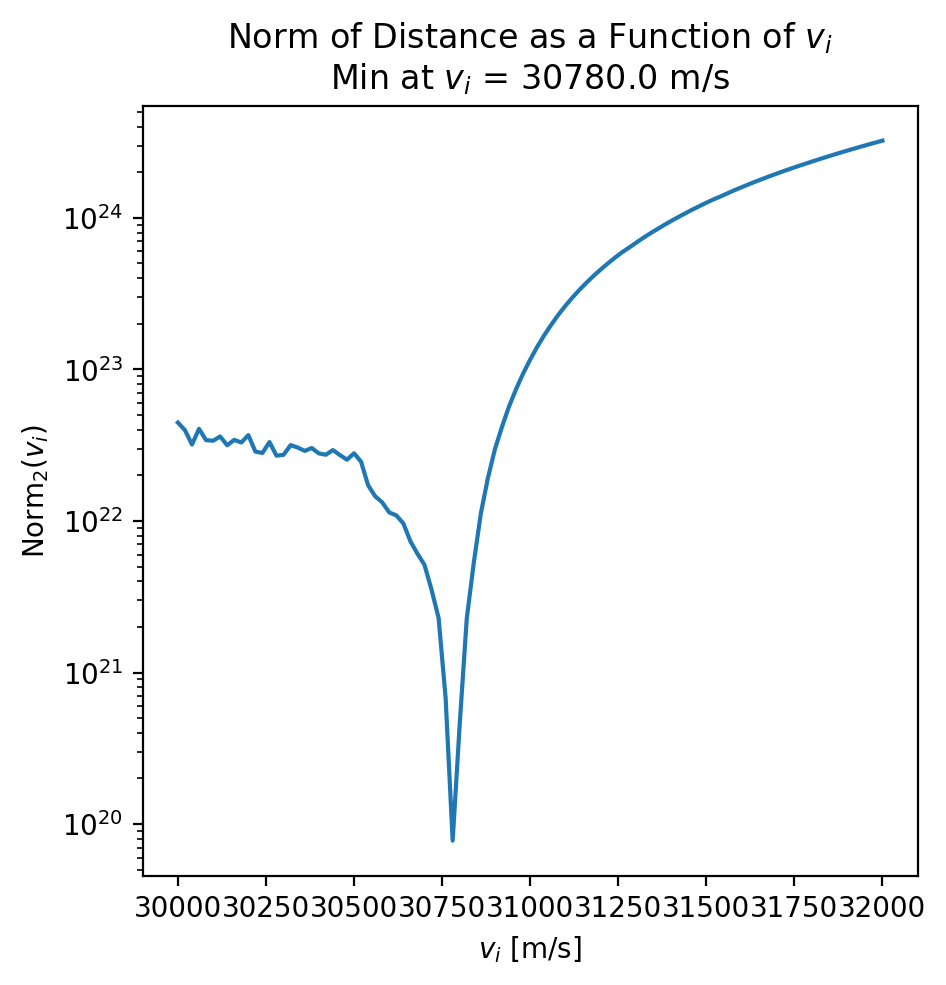

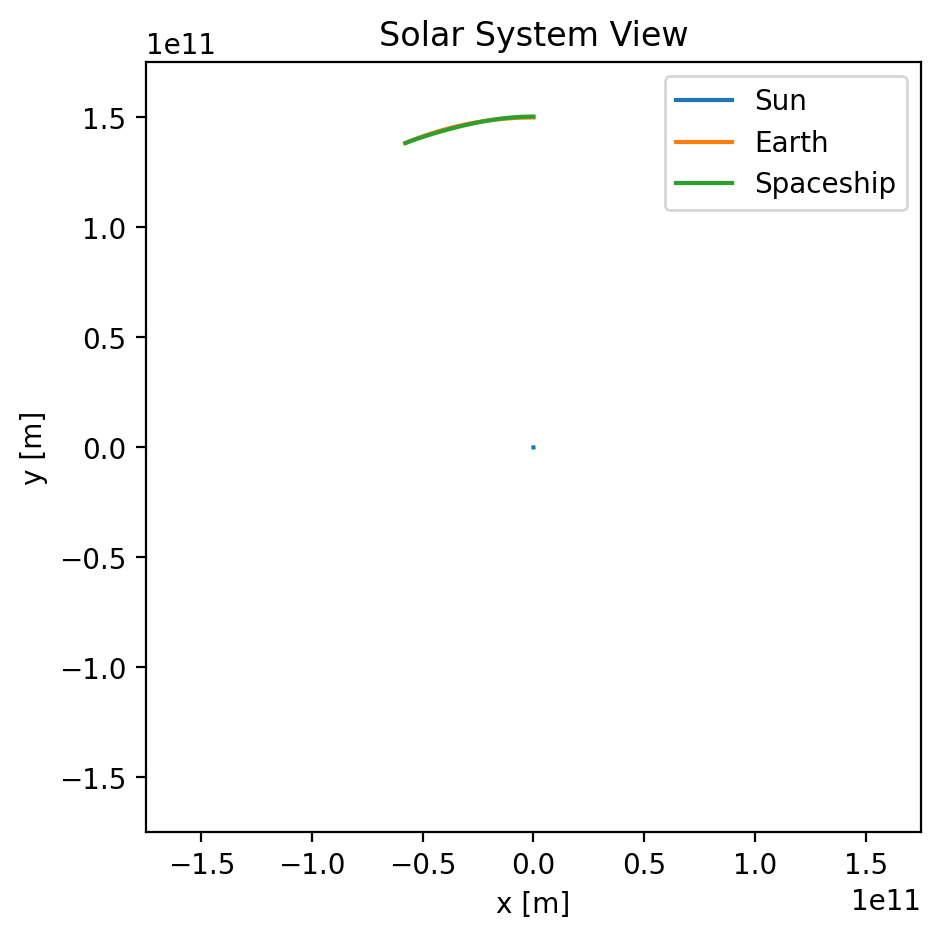

<Figure size 640x480 with 0 Axes>

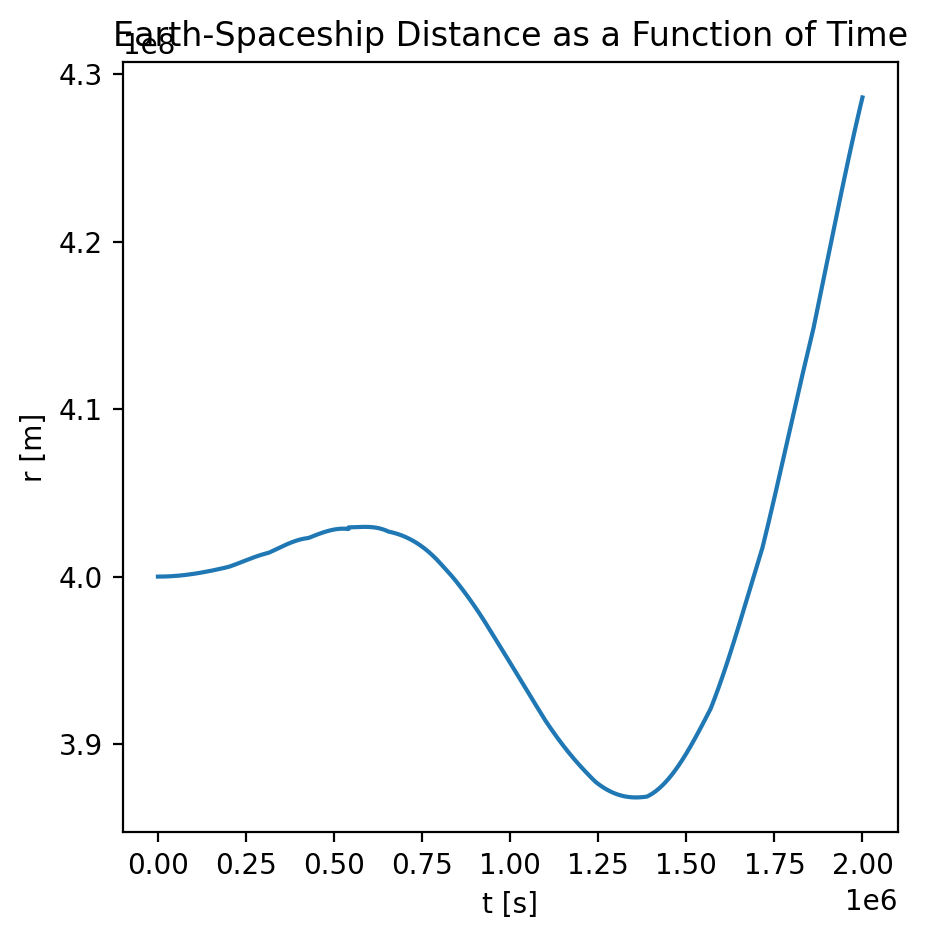

In [4]:
# Define an array for the different values I will test
momentum_values = Spaceship.m * np.linspace(30e3, 32e3, 101)
# Create an empty array to populate with norm values
norms = np.zeros_like(momentum_values)

for i in range(len(momentum_values)):
    
    # Clean initialization of each object
    Sun     = planet(name = 'Sun',     position = [0, 0, 0],             velocity = [0, 0, 0],        mass = 2e30)
    Earth   = planet(name = 'Earth',   position = [0,1.5e11, 0],         velocity = [-29.78e3, 0, 0], mass = 6e24)
    Spaceship = spaceship(name = 'Spaceship', position = [0, 1.5e11 + 4e8, 0], velocity = [-(31.5e3), 0 , 0], rocket_params = rocket_params)
    objects = [Sun, Earth, Spaceship]
    
    # Redefine the IC
    y0 = np.array([0, 0, 0, 0.0, 0.0, 0.0, 0, 150000000000.0, 0, -1.7868e+29, 0.0, 0.0, 0, 150400000000.0, 0, -18900000000.0, 0.0, 0.0])
    # Assign the new momentum
    y0[-3] = -1 * momentum_values[i]
    
    t_span = [0,2e6]
    t_eval = np.linspace(0, 2e6, 1000000)

    # Running the ODE solver
    sol = solve_ivp(f, t_span, y0, method='LSODA', t_eval=t_eval, min_step=1)

    # Assigning solutions for Sun
    objects[0].sol_rx = sol.y[0]
    objects[0].sol_ry = sol.y[1]
    objects[0].sol_rz = sol.y[2]
    objects[0].sol_px = sol.y[3]
    objects[0].sol_py = sol.y[4]
    objects[0].sol_pz = sol.y[5]
    objects[0].sol_t = sol.t

    # Assigning solutions for Earth
    objects[1].sol_rx = sol.y[6]
    objects[1].sol_ry = sol.y[7]
    objects[1].sol_rz = sol.y[8]
    objects[1].sol_px = sol.y[9]
    objects[1].sol_py = sol.y[10]
    objects[1].sol_pz = sol.y[11]
    objects[1].sol_t = sol.t

    # Assigning solutions for Spaceship
    objects[2].sol_rx = sol.y[12]
    objects[2].sol_ry = sol.y[13]
    objects[2].sol_rz = sol.y[14]
    objects[2].sol_px = sol.y[15]
    objects[2].sol_py = sol.y[16]
    objects[2].sol_pz = sol.y[17]
    objects[2].sol_t = sol.t
    
    norms[i] = np.sum((((Spaceship.sol_ry-Earth.sol_ry)**2 + (Spaceship.sol_rx-Earth.sol_rx)**2)**(1/2) - (4e8))**2)
    
plt.figure(figsize=(5,5), dpi=200)
plt.plot(momentum_values / Spaceship.m, norms)
plt.yscale('log')
plt.xlabel(r'$v_i$ [m/s]')
plt.ylabel(r'Norm$_2$($v_i$)')
plt.title(fr'Norm of Distance as a Function of $v_i$''\nMin at 'r'$v_i$ = 'f'{momentum_values[np.argmin(norms)] / Spaceship.m} m/s')
plt.show()

# Clean initialization of each object
Sun     = planet(name = 'Sun',     position = [0, 0, 0],             velocity = [0, 0, 0],        mass = 2e30)
Earth   = planet(name = 'Earth',   position = [0,1.5e11, 0],         velocity = [-29.78e3, 0, 0], mass = 6e24)
Spaceship = spaceship(name = 'Spaceship', position = [0, 1.5e11 + 4e8, 0], velocity = [-(31.5e3), 0 , 0], rocket_params = rocket_params)
objects = [Sun, Earth, Spaceship]

# Defining in initial conditions
y0 = np.array([0, 0, 0, 0.0, 0.0, 0.0, 0, 150000000000.0, 0, -1.7868e+29, 0.0, 0.0, 0, 150400000000.0, 0, -1 * momentum_values[np.argmin(norms)], 0.0, 0.0])
t_span = [0,2e6]
t_eval = np.linspace(0, 2e6, 1000000)

# Running the ODE solver
sol = solve_ivp(f, t_span, y0, method='LSODA', t_eval=t_eval, min_step=1)

# Saving the solutions
t = sol.t
# Assigning solutions for Sun
objects[0].sol_rx = sol.y[0]
objects[0].sol_ry = sol.y[1]
objects[0].sol_rz = sol.y[2]
objects[0].sol_px = sol.y[3]
objects[0].sol_py = sol.y[4]
objects[0].sol_pz = sol.y[5]
objects[0].sol_t = sol.t

# Assigning solutions for Earth
objects[1].sol_rx = sol.y[6]
objects[1].sol_ry = sol.y[7]
objects[1].sol_rz = sol.y[8]
objects[1].sol_px = sol.y[9]
objects[1].sol_py = sol.y[10]
objects[1].sol_pz = sol.y[11]
objects[1].sol_t = sol.t

# Assigning solutions for Spaceship
objects[2].sol_rx = sol.y[12]
objects[2].sol_ry = sol.y[13]
objects[2].sol_rz = sol.y[14]
objects[2].sol_px = sol.y[15]
objects[2].sol_py = sol.y[16]
objects[2].sol_pz = sol.y[17]
objects[2].sol_t = sol.t

############
# Some plots
############

# Plot Solar System View
plt.figure(figsize=(5,5), dpi=200)
plt.plot(Sun.sol_rx, Sun.sol_ry, label='Sun')
plt.plot(Earth.sol_rx, Earth.sol_ry, label='Earth')
plt.plot(Spaceship.sol_rx, Spaceship.sol_ry, label='Spaceship')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.xlim(-1.75e11, 1.75e11)
plt.ylim(-1.75e11, 1.75e11)
plt.title('Solar System View')
plt.show()

# Plot Distance of the Spaceship from Earth.
plt.figure()
plt.figure(figsize=(5,5), dpi=200)
plt.plot(Spaceship.sol_t, ((Spaceship.sol_ry-Earth.sol_ry)**2 + (Spaceship.sol_rx-Earth.sol_rx)**2)**(1/2))
plt.xlabel('t [s]')
plt.ylabel('r [m]')
plt.title('Earth-Spaceship Distance as a Function of Time')
plt.show()

This looks good at the start, but I do not like how the spaceship seems to lose Earth near the end. I want to do this for a better initial guess and evaluate initial values at a fine mesh around this value to see if I can find a more stable option.

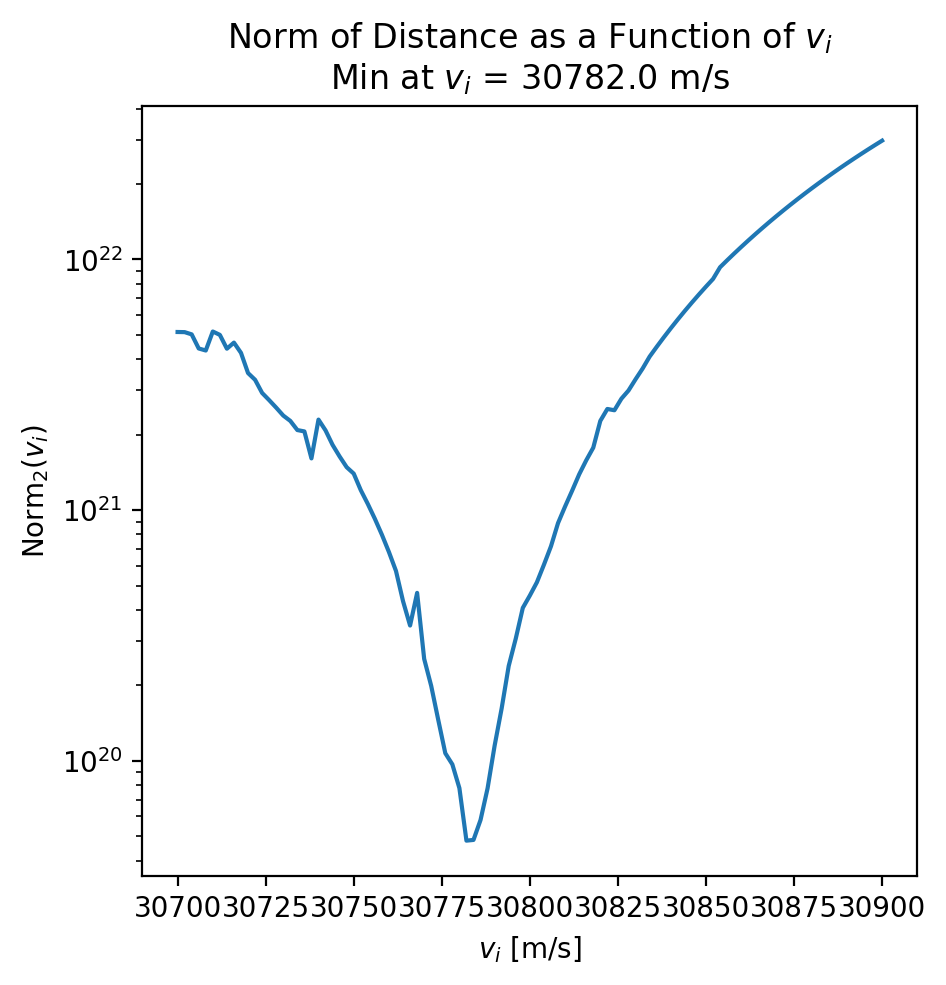

<Figure size 640x480 with 0 Axes>

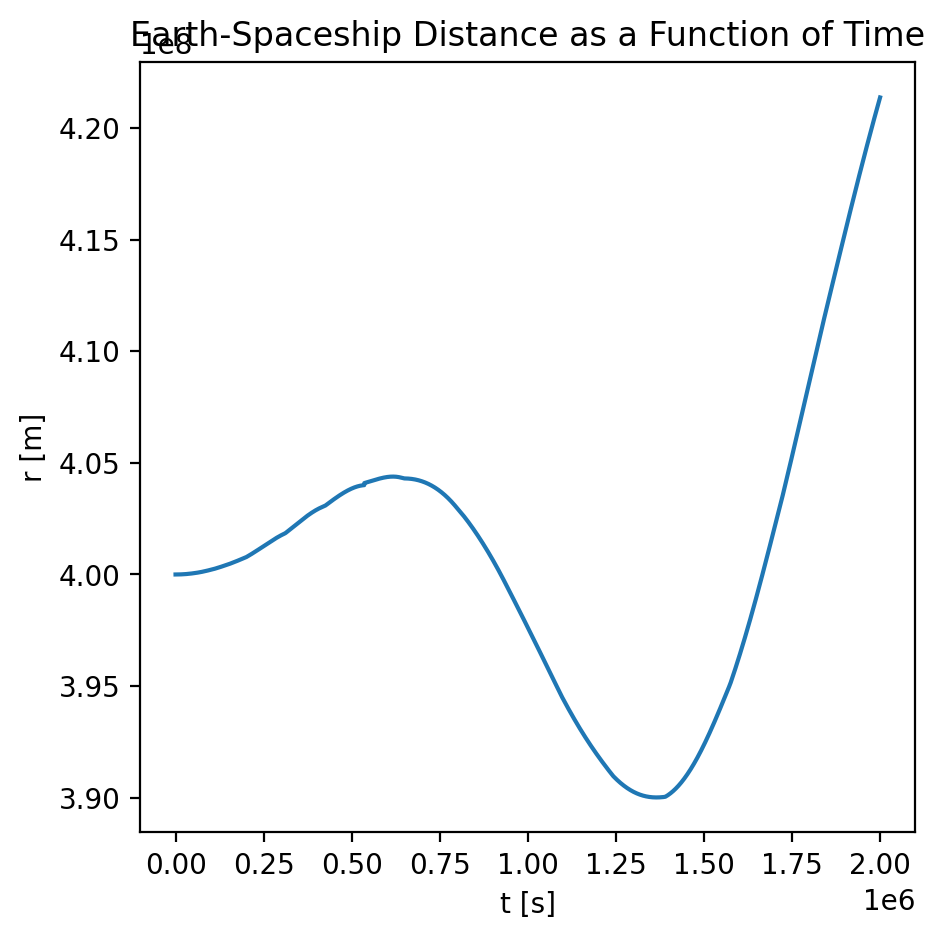

In [5]:
# Define some new momentum values
momentum_values = Spaceship.m * np.linspace(30.7e3, 30.9e3, 101)
# Create an empty array to populate with norm values
norms = np.zeros_like(momentum_values)

for i in range(len(momentum_values)):
    
    # Clean initialization of each object
    Sun     = planet(name = 'Sun',     position = [0, 0, 0],             velocity = [0, 0, 0],        mass = 2e30)
    Earth   = planet(name = 'Earth',   position = [0,1.5e11, 0],         velocity = [-29.78e3, 0, 0], mass = 6e24)
    Spaceship = spaceship(name = 'Spaceship', position = [0, 1.5e11 + 4e8, 0], velocity = [-(31.5e3), 0 , 0], rocket_params = rocket_params)
    objects = [Sun, Earth, Spaceship]
    
    # Redefine the IC
    y0 = np.array([0, 0, 0, 0.0, 0.0, 0.0, 0, 150000000000.0, 0, -1.7868e+29, 0.0, 0.0, 0, 150400000000.0, 0, -18900000000.0, 0.0, 0.0])
    # Assign the new momentum
    y0[-3] = -1 * momentum_values[i]
    
    t_span = [0,2e6]
    t_eval = np.linspace(0, 2e6, 1000000)

    # Running the ODE solver
    sol = solve_ivp(f, t_span, y0, method='LSODA', t_eval=t_eval, min_step=1)

    # Assigning solutions for Sun
    objects[0].sol_rx = sol.y[0]
    objects[0].sol_ry = sol.y[1]
    objects[0].sol_rz = sol.y[2]
    objects[0].sol_px = sol.y[3]
    objects[0].sol_py = sol.y[4]
    objects[0].sol_pz = sol.y[5]
    objects[0].sol_t = sol.t

    # Assigning solutions for Earth
    objects[1].sol_rx = sol.y[6]
    objects[1].sol_ry = sol.y[7]
    objects[1].sol_rz = sol.y[8]
    objects[1].sol_px = sol.y[9]
    objects[1].sol_py = sol.y[10]
    objects[1].sol_pz = sol.y[11]
    objects[1].sol_t = sol.t

    # Assigning solutions for Spaceship
    objects[2].sol_rx = sol.y[12]
    objects[2].sol_ry = sol.y[13]
    objects[2].sol_rz = sol.y[14]
    objects[2].sol_px = sol.y[15]
    objects[2].sol_py = sol.y[16]
    objects[2].sol_pz = sol.y[17]
    objects[2].sol_t = sol.t
    
    norms[i] = np.sum((((Spaceship.sol_ry-Earth.sol_ry)**2 + (Spaceship.sol_rx-Earth.sol_rx)**2)**(1/2) - (4e8))**2)
    
plt.figure(figsize=(5,5), dpi=200)
plt.plot(momentum_values / Spaceship.m, norms)
plt.yscale('log')
plt.xlabel(r'$v_i$ [m/s]')
plt.ylabel(r'Norm$_2$($v_i$)')
plt.title(fr'Norm of Distance as a Function of $v_i$''\nMin at 'r'$v_i$ = 'f'{momentum_values[np.argmin(norms)] / Spaceship.m} m/s')
plt.show()

# Clean initialization of each object
Sun     = planet(name = 'Sun',     position = [0, 0, 0],             velocity = [0, 0, 0],        mass = 2e30)
Earth   = planet(name = 'Earth',   position = [0,1.5e11, 0],         velocity = [-29.78e3, 0, 0], mass = 6e24)
Spaceship = spaceship(name = 'Spaceship', position = [0, 1.5e11 + 4e8, 0], velocity = [-(31.5e3), 0 , 0], rocket_params = rocket_params)
objects = [Sun, Earth, Spaceship]

# Defining in initial conditions
y0 = np.array([0, 0, 0, 0.0, 0.0, 0.0, 0, 150000000000.0, 0, -1.7868e+29, 0.0, 0.0, 0, 150400000000.0, 0, -1 * momentum_values[np.argmin(norms)], 0.0, 0.0])
t_span = [0,2e6]
t_eval = np.linspace(0, 2e6, 1000000)

# Running the ODE solver
sol = solve_ivp(f, t_span, y0, method='LSODA', t_eval=t_eval, min_step=1)

# Saving the solutions
t = sol.t
# Assigning solutions for Sun
objects[0].sol_rx = sol.y[0]
objects[0].sol_ry = sol.y[1]
objects[0].sol_rz = sol.y[2]
objects[0].sol_px = sol.y[3]
objects[0].sol_py = sol.y[4]
objects[0].sol_pz = sol.y[5]
objects[0].sol_t = sol.t

# Assigning solutions for Earth
objects[1].sol_rx = sol.y[6]
objects[1].sol_ry = sol.y[7]
objects[1].sol_rz = sol.y[8]
objects[1].sol_px = sol.y[9]
objects[1].sol_py = sol.y[10]
objects[1].sol_pz = sol.y[11]
objects[1].sol_t = sol.t

# Assigning solutions for Spaceship
objects[2].sol_rx = sol.y[12]
objects[2].sol_ry = sol.y[13]
objects[2].sol_rz = sol.y[14]
objects[2].sol_px = sol.y[15]
objects[2].sol_py = sol.y[16]
objects[2].sol_pz = sol.y[17]
objects[2].sol_t = sol.t

############
# Some plots
############

# Plot Distance of the Spaceship from Earth.
plt.figure()
plt.figure(figsize=(5,5), dpi=200)
plt.plot(Spaceship.sol_t, ((Spaceship.sol_ry-Earth.sol_ry)**2 + (Spaceship.sol_rx-Earth.sol_rx)**2)**(1/2))
plt.xlabel('t [s]')
plt.ylabel('r [m]')
plt.title('Earth-Spaceship Distance as a Function of Time')
plt.show()

That didn't change much. I'm going to try a 3-norm instead of a 2-norm for this region. Maybe that will discourage the computer for selecting initial conditions where the spaceship appears to leave Earth.

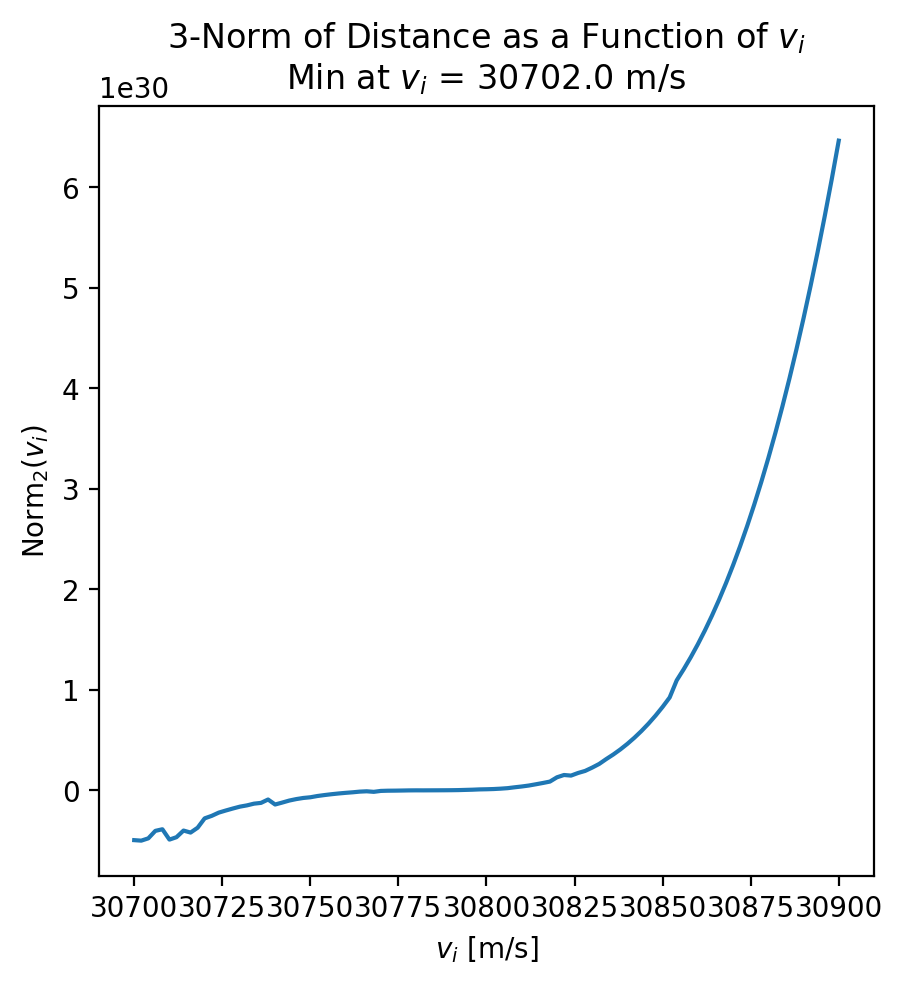

<Figure size 640x480 with 0 Axes>

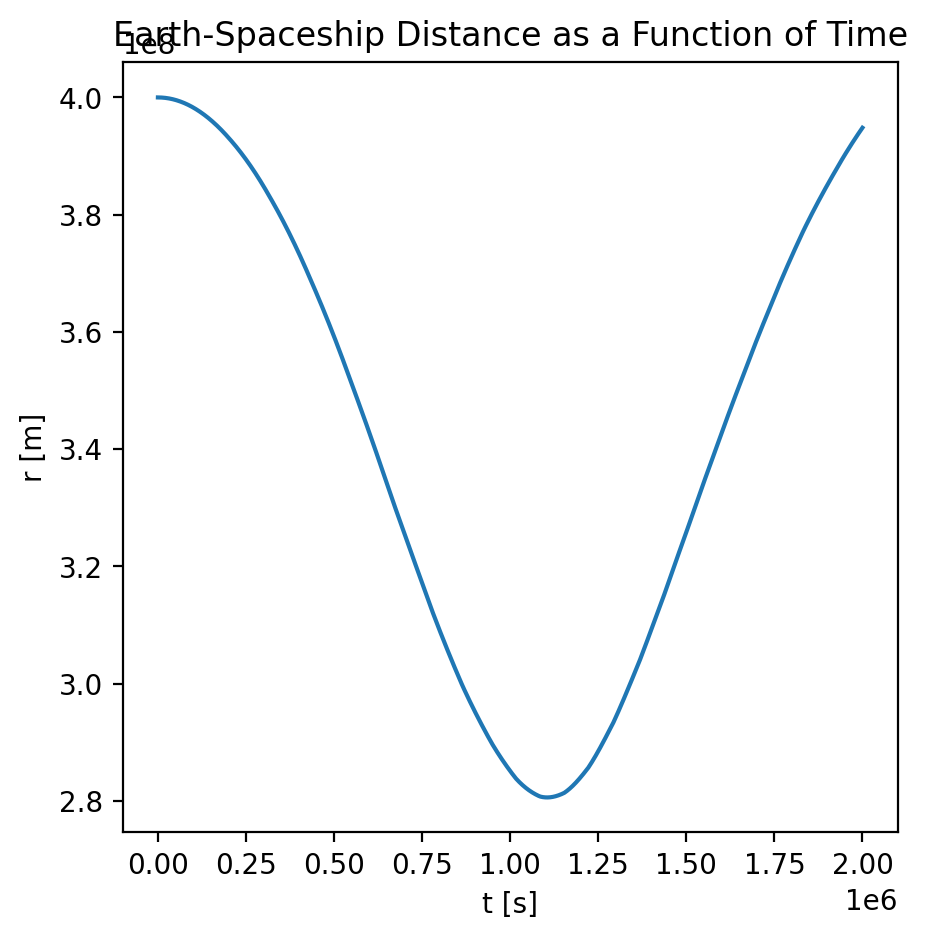

In [6]:
# Define some new momentum values
momentum_values = Spaceship.m * np.linspace(30.7e3, 30.9e3, 101)
# Create an empty array to populate with norm values
norms = np.zeros_like(momentum_values)

for i in range(len(momentum_values)):
    
    # Clean initialization of each object
    Sun     = planet(name = 'Sun',     position = [0, 0, 0],             velocity = [0, 0, 0],        mass = 2e30)
    Earth   = planet(name = 'Earth',   position = [0,1.5e11, 0],         velocity = [-29.78e3, 0, 0], mass = 6e24)
    Spaceship = spaceship(name = 'Spaceship', position = [0, 1.5e11 + 4e8, 0], velocity = [-(31.5e3), 0 , 0], rocket_params = rocket_params)
    objects = [Sun, Earth, Spaceship]
    
    # Redefine the IC
    y0 = np.array([0, 0, 0, 0.0, 0.0, 0.0, 0, 150000000000.0, 0, -1.7868e+29, 0.0, 0.0, 0, 150400000000.0, 0, -18900000000.0, 0.0, 0.0])
    # Assign the new momentum
    y0[-3] = -1 * momentum_values[i]
    
    t_span = [0,2e6]
    t_eval = np.linspace(0, 2e6, 1000000)

    # Running the ODE solver
    sol = solve_ivp(f, t_span, y0, method='LSODA', t_eval=t_eval, min_step=1)

    # Assigning solutions for Sun
    objects[0].sol_rx = sol.y[0]
    objects[0].sol_ry = sol.y[1]
    objects[0].sol_rz = sol.y[2]
    objects[0].sol_px = sol.y[3]
    objects[0].sol_py = sol.y[4]
    objects[0].sol_pz = sol.y[5]
    objects[0].sol_t = sol.t

    # Assigning solutions for Earth
    objects[1].sol_rx = sol.y[6]
    objects[1].sol_ry = sol.y[7]
    objects[1].sol_rz = sol.y[8]
    objects[1].sol_px = sol.y[9]
    objects[1].sol_py = sol.y[10]
    objects[1].sol_pz = sol.y[11]
    objects[1].sol_t = sol.t

    # Assigning solutions for Spaceship
    objects[2].sol_rx = sol.y[12]
    objects[2].sol_ry = sol.y[13]
    objects[2].sol_rz = sol.y[14]
    objects[2].sol_px = sol.y[15]
    objects[2].sol_py = sol.y[16]
    objects[2].sol_pz = sol.y[17]
    objects[2].sol_t = sol.t
    
    norms[i] = np.sum((((Spaceship.sol_ry-Earth.sol_ry)**2 + (Spaceship.sol_rx-Earth.sol_rx)**2)**(1/2) - (4e8))**3)
    
plt.figure(figsize=(5,5), dpi=200)
plt.plot(momentum_values / Spaceship.m, norms)
plt.xlabel(r'$v_i$ [m/s]')
plt.ylabel(r'Norm$_2$($v_i$)')
plt.title(fr'3-Norm of Distance as a Function of $v_i$''\nMin at 'r'$v_i$ = 'f'{momentum_values[np.argmin(norms)] / Spaceship.m} m/s')
plt.show()

# Clean initialization of each object
Sun     = planet(name = 'Sun',     position = [0, 0, 0],             velocity = [0, 0, 0],        mass = 2e30)
Earth   = planet(name = 'Earth',   position = [0,1.5e11, 0],         velocity = [-29.78e3, 0, 0], mass = 6e24)
Spaceship = spaceship(name = 'Spaceship', position = [0, 1.5e11 + 4e8, 0], velocity = [-(31.5e3), 0 , 0], rocket_params = rocket_params)
objects = [Sun, Earth, Spaceship]

# Defining in initial conditions
y0 = np.array([0, 0, 0, 0.0, 0.0, 0.0, 0, 150000000000.0, 0, -1.7868e+29, 0.0, 0.0, 0, 150400000000.0, 0, -1 * momentum_values[np.argmin(norms)], 0.0, 0.0])
t_span = [0,2e6]
t_eval = np.linspace(0, 2e6, 1000000)

# Running the ODE solver
sol = solve_ivp(f, t_span, y0, method='LSODA', t_eval=t_eval, min_step=1)

# Saving the solutions
t = sol.t
# Assigning solutions for Sun
objects[0].sol_rx = sol.y[0]
objects[0].sol_ry = sol.y[1]
objects[0].sol_rz = sol.y[2]
objects[0].sol_px = sol.y[3]
objects[0].sol_py = sol.y[4]
objects[0].sol_pz = sol.y[5]
objects[0].sol_t = sol.t

# Assigning solutions for Earth
objects[1].sol_rx = sol.y[6]
objects[1].sol_ry = sol.y[7]
objects[1].sol_rz = sol.y[8]
objects[1].sol_px = sol.y[9]
objects[1].sol_py = sol.y[10]
objects[1].sol_pz = sol.y[11]
objects[1].sol_t = sol.t

# Assigning solutions for Spaceship
objects[2].sol_rx = sol.y[12]
objects[2].sol_ry = sol.y[13]
objects[2].sol_rz = sol.y[14]
objects[2].sol_px = sol.y[15]
objects[2].sol_py = sol.y[16]
objects[2].sol_pz = sol.y[17]
objects[2].sol_t = sol.t

############
# Some plots
############

# Plot Distance of the Spaceship from Earth.
plt.figure()
plt.figure(figsize=(5,5), dpi=200)
plt.plot(Spaceship.sol_t, ((Spaceship.sol_ry-Earth.sol_ry)**2 + (Spaceship.sol_rx-Earth.sol_rx)**2)**(1/2))
plt.xlabel('t [s]')
plt.ylabel('r [m]')
plt.title('Earth-Spaceship Distance as a Function of Time')
plt.show()

This looks much better! It looks like doing this in a 3-norm had the desired effect. This spaceship orbit looks bound. 

I kept in this process because it really encompasses what turned out to be so challenging about qualifying what a stable orbit is. All throughout this project I had to think of different ways to qualify what "stability" really is and work out methods to get the computer to find what I really want. 

# Writing the code for a burning rocket

Everything below this comment has changed since my presentation. I realized that the integrator package I am using is behaving strangely, so I rewrote the code in a way that made it more accurate and handled more of the spaceship parameters in the spaceship object itself, instead of keeping track of them externally and passing them in. Even with this fix, the code is still strange and some parts do not work as expected. I have written a more detailed breakdown of what went right and what went wrong at the end of the notebook. 

I am not going to write a script for this one, I am just going to edit the existing one for the 5 object system. It is a less general solution, but easier for me. 

C:\Users\Graham\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Repeated error test failures (internal error).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


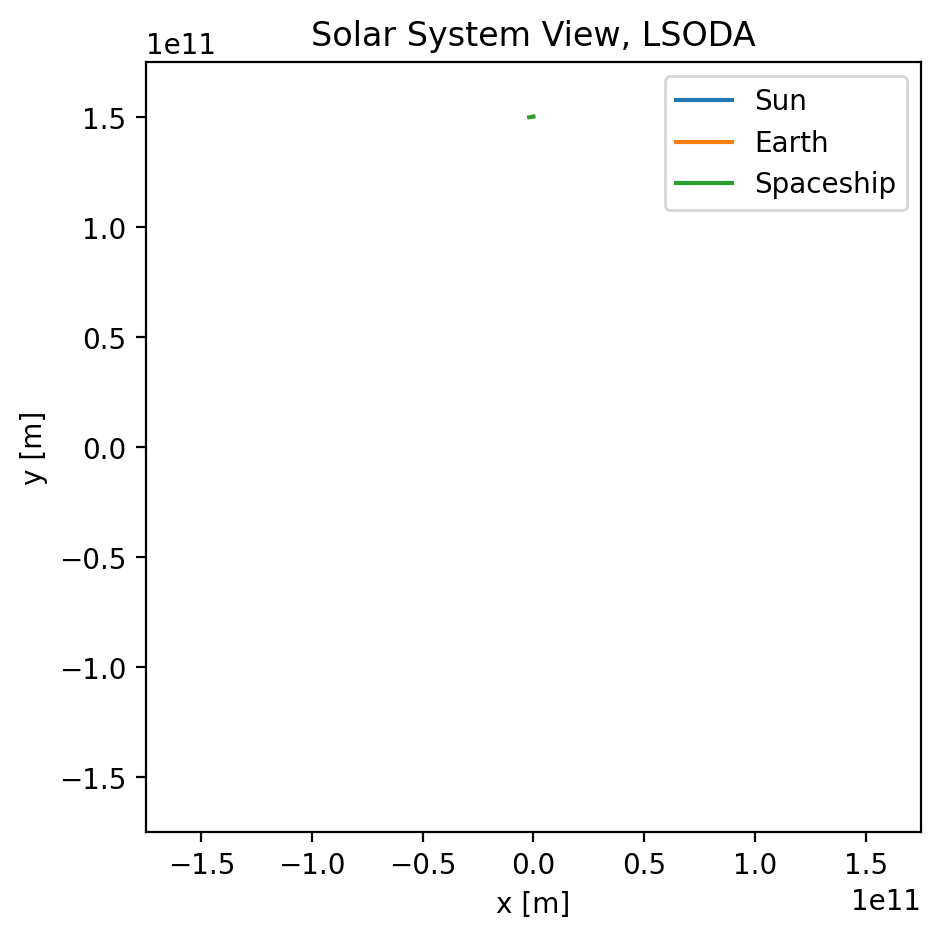

<Figure size 640x480 with 0 Axes>

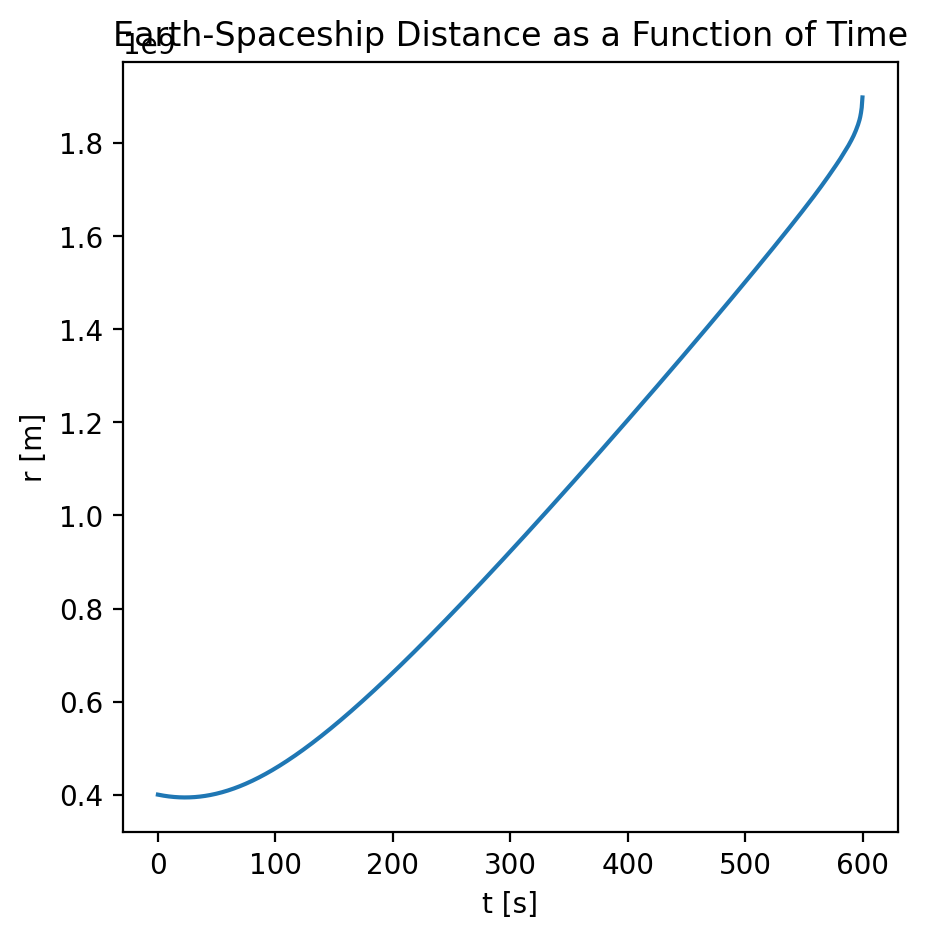

In [7]:
# Clean assignment of objects
Sun     = planet(name = 'Sun',     position = [0, 0, 0],             velocity = [0, 0, 0],        mass = 2e30)
Earth   = planet(name = 'Earth',   position = [0,1.5e11, 0],         velocity = [-29.78e3, 0, 0], mass = 6e24)
Mars    = planet(name = 'Mars',    position = [-1.5 * 1.5e11, 0, 0], velocity = [0, -24e3, 0],    mass = 6e23)
Jupiter = planet(name = 'Jupiter', position = [0, 5.2 * 1.5e11, 0],  velocity = [-13e3, 0, 0],    mass = 2e27)

rocket_params = [1e3, 1e3, 6e5, 3e3, 10, 0.7] # dry mass, burn rate, total mass, v_exh, burn angle, percent of fuel on start
Spaceship = spaceship(name = 'Spaceship', position = [0, 1.5e11 - 3562000000, 0], velocity = [(30510), 0 , 0], rocket_params = rocket_params)

objects = [Sun, Earth, Mars, Jupiter, Spaceship]

def f_burn(t,y):
    '''
    This function creates the ODE function for the scipy integrator with rocket burn.
    '''
    
    G = 6.67e-11
    
    # Adjust the spaceship mass before any calculations
    Spaceship.m = np.abs(Spaceship.total_mass - t * Spaceship.burn_rate)
    
    # Defining the masses, pulls in updated spaceship mass
    m = np.array([0])
    for o in range(len(objects)):
        m = np.append(m, objects[o].m)
    
    ###################### 
    # Variable definitions 
    ###################### 
    
    # Sun variable definitions 
    x1 = y[0]
    y1 = y[1]
    z1 = y[2]
    px1 = y[3]
    py1 = y[4]
    pz1 = y[5]    
    
    # Earth variable definitions 
    x2 = y[6]
    y2 = y[7]
    z2 = y[8]
    px2 = y[9]
    py2 = y[10]
    pz2 = y[11]    
    
    # Mars variable definitions 
    x3 = y[12]
    y3 = y[13]
    z3 = y[14]
    px3 = y[15]
    py3 = y[16]
    pz3 = y[17]    
    
    # Jupiter variable definitions 
    x4 = y[18]
    y4 = y[19]
    z4 = y[20]
    px4 = y[21]
    py4 = y[22]
    pz4 = y[23]    
    
    # Spaceship variable definitions 
    x5 = y[24]
    y5 = y[25]
    z5 = y[26]
    px5 = y[27]
    py5 = y[28]
    pz5 = y[29]

    ######################## 
    # Derivative definitions 
    ######################## 
    
    # Sun derivative definitions 
    dx1 = px1 / m[1]
    dy1 = py1 / m[1]
    dz1 = pz1 / m[1]
    dpx1 = -G * m[1] * ( m[2] * (x1 - x2) / (((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) ** (3/2)) + m[3] * (x1 - x3) / (((x1 - x3)**2 + (y1 - y3)**2 + (z1 - z3)**2) ** (3/2)) + m[4] * (x1 - x4) / (((x1 - x4)**2 + (y1 - y4)**2 + (z1 - z4)**2) ** (3/2)) + m[5] * (x1 - x5) / (((x1 - x5)**2 + (y1 - y5)**2 + (z1 - z5)**2) ** (3/2)) )
    dpy1 = -G * m[1] * ( m[2] * (y1 - y2) / (((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) ** (3/2)) + m[3] * (y1 - y3) / (((x1 - x3)**2 + (y1 - y3)**2 + (z1 - z3)**2) ** (3/2)) + m[4] * (y1 - y4) / (((x1 - x4)**2 + (y1 - y4)**2 + (z1 - z4)**2) ** (3/2)) + m[5] * (y1 - y5) / (((x1 - x5)**2 + (y1 - y5)**2 + (z1 - z5)**2) ** (3/2)) )
    dpz1 = -G * m[1] * ( m[2] * (z1 - z2) / (((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) ** (3/2)) + m[3] * (z1 - z3) / (((x1 - x3)**2 + (y1 - y3)**2 + (z1 - z3)**2) ** (3/2)) + m[4] * (z1 - z4) / (((x1 - x4)**2 + (y1 - y4)**2 + (z1 - z4)**2) ** (3/2)) + m[5] * (z1 - z5) / (((x1 - x5)**2 + (y1 - y5)**2 + (z1 - z5)**2) ** (3/2)) )
    
    # Earth derivative definitions 
    dx2 = px2 / m[2]
    dy2 = py2 / m[2]
    dz2 = pz2 / m[2]
    dpx2 = -G * m[2] * ( m[1] * (x2 - x1) / (((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2) ** (3/2)) + m[3] * (x2 - x3) / (((x2 - x3)**2 + (y2 - y3)**2 + (z2 - z3)**2) ** (3/2)) + m[4] * (x2 - x4) / (((x2 - x4)**2 + (y2 - y4)**2 + (z2 - z4)**2) ** (3/2)) + m[5] * (x2 - x5) / (((x2 - x5)**2 + (y2 - y5)**2 + (z2 - z5)**2) ** (3/2)) )
    dpy2 = -G * m[2] * ( m[1] * (y2 - y1) / (((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2) ** (3/2)) + m[3] * (y2 - y3) / (((x2 - x3)**2 + (y2 - y3)**2 + (z2 - z3)**2) ** (3/2)) + m[4] * (y2 - y4) / (((x2 - x4)**2 + (y2 - y4)**2 + (z2 - z4)**2) ** (3/2)) + m[5] * (y2 - y5) / (((x2 - x5)**2 + (y2 - y5)**2 + (z2 - z5)**2) ** (3/2)) )
    dpz2 = -G * m[2] * ( m[1] * (z2 - z1) / (((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2) ** (3/2)) + m[3] * (z2 - z3) / (((x2 - x3)**2 + (y2 - y3)**2 + (z2 - z3)**2) ** (3/2)) + m[4] * (z2 - z4) / (((x2 - x4)**2 + (y2 - y4)**2 + (z2 - z4)**2) ** (3/2)) + m[5] * (z2 - z5) / (((x2 - x5)**2 + (y2 - y5)**2 + (z2 - z5)**2) ** (3/2)) )
    
    # Mars derivative definitions 
    dx3 = px3 / m[3]
    dy3 = py3 / m[3]
    dz3 = pz3 / m[3]
    dpx3 = -G * m[3] * ( m[1] * (x3 - x1) / (((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2) ** (3/2)) + m[2] * (x3 - x2) / (((x3 - x2)**2 + (y3 - y2)**2 + (z3 - z2)**2) ** (3/2)) + m[4] * (x3 - x4) / (((x3 - x4)**2 + (y3 - y4)**2 + (z3 - z4)**2) ** (3/2)) + m[5] * (x3 - x5) / (((x3 - x5)**2 + (y3 - y5)**2 + (z3 - z5)**2) ** (3/2)) )
    dpy3 = -G * m[3] * ( m[1] * (y3 - y1) / (((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2) ** (3/2)) + m[2] * (y3 - y2) / (((x3 - x2)**2 + (y3 - y2)**2 + (z3 - z2)**2) ** (3/2)) + m[4] * (y3 - y4) / (((x3 - x4)**2 + (y3 - y4)**2 + (z3 - z4)**2) ** (3/2)) + m[5] * (y3 - y5) / (((x3 - x5)**2 + (y3 - y5)**2 + (z3 - z5)**2) ** (3/2)) )
    dpz3 = -G * m[3] * ( m[1] * (z3 - z1) / (((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2) ** (3/2)) + m[2] * (z3 - z2) / (((x3 - x2)**2 + (y3 - y2)**2 + (z3 - z2)**2) ** (3/2)) + m[4] * (z3 - z4) / (((x3 - x4)**2 + (y3 - y4)**2 + (z3 - z4)**2) ** (3/2)) + m[5] * (z3 - z5) / (((x3 - x5)**2 + (y3 - y5)**2 + (z3 - z5)**2) ** (3/2)) )
    
    # Jupiter derivative definitions 
    dx4 = px4 / m[4]
    dy4 = py4 / m[4]
    dz4 = pz4 / m[4]
    dpx4 = -G * m[4] * ( m[1] * (x4 - x1) / (((x4 - x1)**2 + (y4 - y1)**2 + (z4 - z1)**2) ** (3/2)) + m[2] * (x4 - x2) / (((x4 - x2)**2 + (y4 - y2)**2 + (z4 - z2)**2) ** (3/2)) + m[3] * (x4 - x3) / (((x4 - x3)**2 + (y4 - y3)**2 + (z4 - z3)**2) ** (3/2)) + m[5] * (x4 - x5) / (((x4 - x5)**2 + (y4 - y5)**2 + (z4 - z5)**2) ** (3/2)) )
    dpy4 = -G * m[4] * ( m[1] * (y4 - y1) / (((x4 - x1)**2 + (y4 - y1)**2 + (z4 - z1)**2) ** (3/2)) + m[2] * (y4 - y2) / (((x4 - x2)**2 + (y4 - y2)**2 + (z4 - z2)**2) ** (3/2)) + m[3] * (y4 - y3) / (((x4 - x3)**2 + (y4 - y3)**2 + (z4 - z3)**2) ** (3/2)) + m[5] * (y4 - y5) / (((x4 - x5)**2 + (y4 - y5)**2 + (z4 - z5)**2) ** (3/2)) )
    dpz4 = -G * m[4] * ( m[1] * (z4 - z1) / (((x4 - x1)**2 + (y4 - y1)**2 + (z4 - z1)**2) ** (3/2)) + m[2] * (z4 - z2) / (((x4 - x2)**2 + (y4 - y2)**2 + (z4 - z2)**2) ** (3/2)) + m[3] * (z4 - z3) / (((x4 - x3)**2 + (y4 - y3)**2 + (z4 - z3)**2) ** (3/2)) + m[5] * (z4 - z5) / (((x4 - x5)**2 + (y4 - y5)**2 + (z4 - z5)**2) ** (3/2)) )
    
    # Spaceship derivative definitions, correct for velocity components
    dx5 = px5 / m[5] - Spaceship.burn_rate * Spaceship.v_exhaust * np.cos(Spaceship.burn_angle)
    dy5 = py5 / m[5] - Spaceship.burn_rate * Spaceship.v_exhaust * np.sin(Spaceship.burn_angle)
    dz5 = pz5 / m[5] - Spaceship.burn_rate * Spaceship.v_exhaust * 0
    dpx5 = -G * m[5] * ( m[1] * (x5 - x1) / (((x5 - x1)**2 + (y5 - y1)**2 + (z5 - z1)**2) ** (3/2)) + m[2] * (x5 - x2) / (((x5 - x2)**2 + (y5 - y2)**2 + (z5 - z2)**2) ** (3/2)) + m[3] * (x5 - x3) / (((x5 - x3)**2 + (y5 - y3)**2 + (z5 - z3)**2) ** (3/2)) + m[4] * (x5 - x4) / (((x5 - x4)**2 + (y5 - y4)**2 + (z5 - z4)**2) ** (3/2)) )
    dpy5 = -G * m[5] * ( m[1] * (y5 - y1) / (((x5 - x1)**2 + (y5 - y1)**2 + (z5 - z1)**2) ** (3/2)) + m[2] * (y5 - y2) / (((x5 - x2)**2 + (y5 - y2)**2 + (z5 - z2)**2) ** (3/2)) + m[3] * (y5 - y3) / (((x5 - x3)**2 + (y5 - y3)**2 + (z5 - z3)**2) ** (3/2)) + m[4] * (y5 - y4) / (((x5 - x4)**2 + (y5 - y4)**2 + (z5 - z4)**2) ** (3/2)) )
    dpz5 = -G * m[5] * ( m[1] * (z5 - z1) / (((x5 - x1)**2 + (y5 - y1)**2 + (z5 - z1)**2) ** (3/2)) + m[2] * (z5 - z2) / (((x5 - x2)**2 + (y5 - y2)**2 + (z5 - z2)**2) ** (3/2)) + m[3] * (z5 - z3) / (((x5 - x3)**2 + (y5 - y3)**2 + (z5 - z3)**2) ** (3/2)) + m[4] * (z5 - z4) / (((x5 - x4)**2 + (y5 - y4)**2 + (z5 - z4)**2) ** (3/2)) )
    
    return np.array([dx1, dy1, dz1, dpx1, dpy1, dpz1, dx2, dy2, dz2, dpx2, dpy2, dpz2, dx3, dy3, dz3, dpx3, dpy3, dpz3, dx4, dy4, dz4, dpx4, dpy4, dpz4, dx5, dy5, dz5, dpx5, dpy5, dpz5])

# Defining in initial conditions
y0 = np.array([0, 0, 0, 0.0, 0.0, 0.0, 0, 150000000000.0, 0, -1.7868e+29, 0.0, 0.0, -225000000000.0, 0, 0, 0.0, -1.44e+28, 0.0, 0, 780000000000.0, 0, -2.6e+31, 0.0, 0.0, 0, 150400000000.0, 0, -1.84212e10, 0.0, 0.0])
t_span = [0,Spaceship.burn_time * Spaceship.burn_percent] # Now we burn until half the total fuel is used up.
t_eval = np.linspace(0, Spaceship.burn_time * Spaceship.burn_percent, 100000)

# Running the ODE solver
sol = solve_ivp(f_burn, t_span, y0, method='LSODA', t_eval=t_eval, min_step=0.1)

# Saving the solutions
t = sol.t
# Assigning solutions for Sun
objects[0].sol_rx = sol.y[0]
objects[0].sol_ry = sol.y[1]
objects[0].sol_rz = sol.y[2]
objects[0].sol_px = sol.y[3]
objects[0].sol_py = sol.y[4]
objects[0].sol_pz = sol.y[5]
objects[0].sol_t = sol.t

# Assigning solutions for Earth
objects[1].sol_rx = sol.y[6]
objects[1].sol_ry = sol.y[7]
objects[1].sol_rz = sol.y[8]
objects[1].sol_px = sol.y[9]
objects[1].sol_py = sol.y[10]
objects[1].sol_pz = sol.y[11]
objects[1].sol_t = sol.t

# Assigning solutions for Mars
objects[2].sol_rx = sol.y[12]
objects[2].sol_ry = sol.y[13]
objects[2].sol_rz = sol.y[14]
objects[2].sol_px = sol.y[15]
objects[2].sol_py = sol.y[16]
objects[2].sol_pz = sol.y[17]
objects[2].sol_t = sol.t

# Assigning solutions for Jupiter
objects[3].sol_rx = sol.y[18]
objects[3].sol_ry = sol.y[19]
objects[3].sol_rz = sol.y[20]
objects[3].sol_px = sol.y[21]
objects[3].sol_py = sol.y[22]
objects[3].sol_pz = sol.y[23]
objects[3].sol_t = sol.t

# Assigning solutions for Spaceship
objects[4].sol_rx = sol.y[24]
objects[4].sol_ry = sol.y[25]
objects[4].sol_rz = sol.y[26]
objects[4].sol_px = sol.y[27]
objects[4].sol_py = sol.y[28]
objects[4].sol_pz = sol.y[29]
objects[4].sol_t = sol.t

# Plot Solar System View
plt.figure(figsize=(5,5), dpi=200)
plt.plot(Sun.sol_rx, Sun.sol_ry, label='Sun')
plt.plot(Earth.sol_rx, Earth.sol_ry, label='Earth')
plt.plot(Spaceship.sol_rx, Spaceship.sol_ry, label='Spaceship')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.xlim(-1.75e11, 1.75e11)
plt.ylim(-1.75e11, 1.75e11)
plt.title('Solar System View, LSODA')
plt.show()

# Plot Distance of the Spaceship from Earth.
plt.figure()
plt.figure(figsize=(5,5), dpi=200)
plt.plot(Spaceship.sol_t, ((Spaceship.sol_ry-Earth.sol_ry)**2 + (Spaceship.sol_rx-Earth.sol_rx)**2)**(1/2))
plt.xlabel('t [s]')
plt.ylabel('r [m]')
plt.title('Earth-Spaceship Distance as a Function of Time')
plt.show()

Nothing much happens in the solar system view because the entire burn only lasts for about 10 minutes with the current parameters. It is visible that the rocket increases it's distance from Earth in the second plot though, this burn is very unrealistic. The rocket travels 1,400,000 km in 10 minutes!

# Shooting to Mars

In [8]:
def f5(t,y):
    '''This function creates the ODE function for the scipy integrator without rocket burn for 5 objects.'''
    
    G = 6.67e-11
    
    # Defining the masses 
    m = np.array([0])
    for o in range(len(objects)):
        m = np.append(m, objects[o].m)
    
    ###################### 
    # Variable definitions 
    ###################### 
    
    # Sun variable definitions 
    x1 = y[0]
    y1 = y[1]
    z1 = y[2]
    px1 = y[3]
    py1 = y[4]
    pz1 = y[5]    
    
    # Earth variable definitions 
    x2 = y[6]
    y2 = y[7]
    z2 = y[8]
    px2 = y[9]
    py2 = y[10]
    pz2 = y[11]    
    
    # Mars variable definitions 
    x3 = y[12]
    y3 = y[13]
    z3 = y[14]
    px3 = y[15]
    py3 = y[16]
    pz3 = y[17]    
    
    # Jupiter variable definitions 
    x4 = y[18]
    y4 = y[19]
    z4 = y[20]
    px4 = y[21]
    py4 = y[22]
    pz4 = y[23]    
    
    # Spaceship variable definitions 
    x5 = y[24]
    y5 = y[25]
    z5 = y[26]
    px5 = y[27]
    py5 = y[28]
    pz5 = y[29]    

    ######################## 
    # Derivative definitions 
    ######################## 
    
    # Sun derivative definitions 
    dx1 = px1 / m[1]
    dy1 = py1 / m[1]
    dz1 = pz1 / m[1]
    dpx1 = -G * m[1] * ( m[2] * (x1 - x2) / (((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) ** (3/2)) + m[3] * (x1 - x3) / (((x1 - x3)**2 + (y1 - y3)**2 + (z1 - z3)**2) ** (3/2)) + m[4] * (x1 - x4) / (((x1 - x4)**2 + (y1 - y4)**2 + (z1 - z4)**2) ** (3/2)) + m[5] * (x1 - x5) / (((x1 - x5)**2 + (y1 - y5)**2 + (z1 - z5)**2) ** (3/2)) )
    dpy1 = -G * m[1] * ( m[2] * (y1 - y2) / (((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) ** (3/2)) + m[3] * (y1 - y3) / (((x1 - x3)**2 + (y1 - y3)**2 + (z1 - z3)**2) ** (3/2)) + m[4] * (y1 - y4) / (((x1 - x4)**2 + (y1 - y4)**2 + (z1 - z4)**2) ** (3/2)) + m[5] * (y1 - y5) / (((x1 - x5)**2 + (y1 - y5)**2 + (z1 - z5)**2) ** (3/2)) )
    dpz1 = -G * m[1] * ( m[2] * (z1 - z2) / (((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) ** (3/2)) + m[3] * (z1 - z3) / (((x1 - x3)**2 + (y1 - y3)**2 + (z1 - z3)**2) ** (3/2)) + m[4] * (z1 - z4) / (((x1 - x4)**2 + (y1 - y4)**2 + (z1 - z4)**2) ** (3/2)) + m[5] * (z1 - z5) / (((x1 - x5)**2 + (y1 - y5)**2 + (z1 - z5)**2) ** (3/2)) )
    
    # Earth derivative definitions 
    dx2 = px2 / m[2]
    dy2 = py2 / m[2]
    dz2 = pz2 / m[2]
    dpx2 = -G * m[2] * ( m[1] * (x2 - x1) / (((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2) ** (3/2)) + m[3] * (x2 - x3) / (((x2 - x3)**2 + (y2 - y3)**2 + (z2 - z3)**2) ** (3/2)) + m[4] * (x2 - x4) / (((x2 - x4)**2 + (y2 - y4)**2 + (z2 - z4)**2) ** (3/2)) + m[5] * (x2 - x5) / (((x2 - x5)**2 + (y2 - y5)**2 + (z2 - z5)**2) ** (3/2)) )
    dpy2 = -G * m[2] * ( m[1] * (y2 - y1) / (((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2) ** (3/2)) + m[3] * (y2 - y3) / (((x2 - x3)**2 + (y2 - y3)**2 + (z2 - z3)**2) ** (3/2)) + m[4] * (y2 - y4) / (((x2 - x4)**2 + (y2 - y4)**2 + (z2 - z4)**2) ** (3/2)) + m[5] * (y2 - y5) / (((x2 - x5)**2 + (y2 - y5)**2 + (z2 - z5)**2) ** (3/2)) )
    dpz2 = -G * m[2] * ( m[1] * (z2 - z1) / (((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2) ** (3/2)) + m[3] * (z2 - z3) / (((x2 - x3)**2 + (y2 - y3)**2 + (z2 - z3)**2) ** (3/2)) + m[4] * (z2 - z4) / (((x2 - x4)**2 + (y2 - y4)**2 + (z2 - z4)**2) ** (3/2)) + m[5] * (z2 - z5) / (((x2 - x5)**2 + (y2 - y5)**2 + (z2 - z5)**2) ** (3/2)) )
    
    # Mars derivative definitions 
    dx3 = px3 / m[3]
    dy3 = py3 / m[3]
    dz3 = pz3 / m[3]
    dpx3 = -G * m[3] * ( m[1] * (x3 - x1) / (((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2) ** (3/2)) + m[2] * (x3 - x2) / (((x3 - x2)**2 + (y3 - y2)**2 + (z3 - z2)**2) ** (3/2)) + m[4] * (x3 - x4) / (((x3 - x4)**2 + (y3 - y4)**2 + (z3 - z4)**2) ** (3/2)) + m[5] * (x3 - x5) / (((x3 - x5)**2 + (y3 - y5)**2 + (z3 - z5)**2) ** (3/2)) )
    dpy3 = -G * m[3] * ( m[1] * (y3 - y1) / (((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2) ** (3/2)) + m[2] * (y3 - y2) / (((x3 - x2)**2 + (y3 - y2)**2 + (z3 - z2)**2) ** (3/2)) + m[4] * (y3 - y4) / (((x3 - x4)**2 + (y3 - y4)**2 + (z3 - z4)**2) ** (3/2)) + m[5] * (y3 - y5) / (((x3 - x5)**2 + (y3 - y5)**2 + (z3 - z5)**2) ** (3/2)) )
    dpz3 = -G * m[3] * ( m[1] * (z3 - z1) / (((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2) ** (3/2)) + m[2] * (z3 - z2) / (((x3 - x2)**2 + (y3 - y2)**2 + (z3 - z2)**2) ** (3/2)) + m[4] * (z3 - z4) / (((x3 - x4)**2 + (y3 - y4)**2 + (z3 - z4)**2) ** (3/2)) + m[5] * (z3 - z5) / (((x3 - x5)**2 + (y3 - y5)**2 + (z3 - z5)**2) ** (3/2)) )
    
    # Jupiter derivative definitions 
    dx4 = px4 / m[4]
    dy4 = py4 / m[4]
    dz4 = pz4 / m[4]
    dpx4 = -G * m[4] * ( m[1] * (x4 - x1) / (((x4 - x1)**2 + (y4 - y1)**2 + (z4 - z1)**2) ** (3/2)) + m[2] * (x4 - x2) / (((x4 - x2)**2 + (y4 - y2)**2 + (z4 - z2)**2) ** (3/2)) + m[3] * (x4 - x3) / (((x4 - x3)**2 + (y4 - y3)**2 + (z4 - z3)**2) ** (3/2)) + m[5] * (x4 - x5) / (((x4 - x5)**2 + (y4 - y5)**2 + (z4 - z5)**2) ** (3/2)) )
    dpy4 = -G * m[4] * ( m[1] * (y4 - y1) / (((x4 - x1)**2 + (y4 - y1)**2 + (z4 - z1)**2) ** (3/2)) + m[2] * (y4 - y2) / (((x4 - x2)**2 + (y4 - y2)**2 + (z4 - z2)**2) ** (3/2)) + m[3] * (y4 - y3) / (((x4 - x3)**2 + (y4 - y3)**2 + (z4 - z3)**2) ** (3/2)) + m[5] * (y4 - y5) / (((x4 - x5)**2 + (y4 - y5)**2 + (z4 - z5)**2) ** (3/2)) )
    dpz4 = -G * m[4] * ( m[1] * (z4 - z1) / (((x4 - x1)**2 + (y4 - y1)**2 + (z4 - z1)**2) ** (3/2)) + m[2] * (z4 - z2) / (((x4 - x2)**2 + (y4 - y2)**2 + (z4 - z2)**2) ** (3/2)) + m[3] * (z4 - z3) / (((x4 - x3)**2 + (y4 - y3)**2 + (z4 - z3)**2) ** (3/2)) + m[5] * (z4 - z5) / (((x4 - x5)**2 + (y4 - y5)**2 + (z4 - z5)**2) ** (3/2)) )
    
    # Spaceship derivative definitions 
    dx5 = px5 / m[5]
    dy5 = py5 / m[5]
    dz5 = pz5 / m[5]
    dpx5 = -G * m[5] * ( m[1] * (x5 - x1) / (((x5 - x1)**2 + (y5 - y1)**2 + (z5 - z1)**2) ** (3/2)) + m[2] * (x5 - x2) / (((x5 - x2)**2 + (y5 - y2)**2 + (z5 - z2)**2) ** (3/2)) + m[3] * (x5 - x3) / (((x5 - x3)**2 + (y5 - y3)**2 + (z5 - z3)**2) ** (3/2)) + m[4] * (x5 - x4) / (((x5 - x4)**2 + (y5 - y4)**2 + (z5 - z4)**2) ** (3/2)) )
    dpy5 = -G * m[5] * ( m[1] * (y5 - y1) / (((x5 - x1)**2 + (y5 - y1)**2 + (z5 - z1)**2) ** (3/2)) + m[2] * (y5 - y2) / (((x5 - x2)**2 + (y5 - y2)**2 + (z5 - z2)**2) ** (3/2)) + m[3] * (y5 - y3) / (((x5 - x3)**2 + (y5 - y3)**2 + (z5 - z3)**2) ** (3/2)) + m[4] * (y5 - y4) / (((x5 - x4)**2 + (y5 - y4)**2 + (z5 - z4)**2) ** (3/2)) )
    dpz5 = -G * m[5] * ( m[1] * (z5 - z1) / (((x5 - x1)**2 + (y5 - y1)**2 + (z5 - z1)**2) ** (3/2)) + m[2] * (z5 - z2) / (((x5 - x2)**2 + (y5 - y2)**2 + (z5 - z2)**2) ** (3/2)) + m[3] * (z5 - z3) / (((x5 - x3)**2 + (y5 - y3)**2 + (z5 - z3)**2) ** (3/2)) + m[4] * (z5 - z4) / (((x5 - x4)**2 + (y5 - y4)**2 + (z5 - z4)**2) ** (3/2)) )
        
    return np.array([dx1, dy1, dz1, dpx1, dpy1, dpz1, dx2, dy2, dz2, dpx2, dpy2, dpz2, dx3, dy3, dz3, dpx3, dpy3, dpz3, dx4, dy4, dz4, dpx4, dpy4, dpz4, dx5, dy5, dz5, dpx5, dpy5, dpz5])

def final_conditions_to_initial_conditions(objects):
    
    '''
    Takes the final positions and velocities for all objects and makes them into the new initial conditions. 
    
    Returns
    -------
    
        y_0 : New initial condition array
        
    '''
    # Create empty initial condition array to fill
    y_0 = np.array([])
    
    for o in range(len(objects)):
        
        # Assign the last solution value to the initial conditions 
        objects[o].rx = objects[o].sol_rx[-1]
        objects[o].ry = objects[o].sol_ry[-1]
        objects[o].rz = objects[o].sol_rz[-1]
        
        objects[o].px = objects[o].sol_px[-1]
        objects[o].py = objects[o].sol_py[-1]
        objects[o].pz = objects[o].sol_pz[-1]
        
        # Clear the solutions
        objects[o].sol_rx = np.array([])
        objects[o].sol_ry = np.array([])
        objects[o].sol_rz = np.array([])
        
        objects[o].sol_px = np.array([])
        objects[o].sol_py = np.array([])
        objects[o].sol_pz = np.array([])
        
        # Fill the initial condition array
        y_0 = np.append(y_0, objects[o].rx)
        y_0 = np.append(y_0, objects[o].ry)
        y_0 = np.append(y_0, objects[o].rz)
        
        y_0 = np.append(y_0, objects[o].px)
        y_0 = np.append(y_0, objects[o].py)
        y_0 = np.append(y_0, objects[o].pz)
        
    return y_0

# How long in seconds will the spacecraft orbit Earth before firing
orbit_times = np.linspace(1, 2*3601, 5)

# What angle with respect to universal reference frame will the rocket fire
burn_angles = np.linspace(-10,45, 6)

# What percentage of the allotted initial fuel will the rocket burn?
burn_percentages = np.linspace(.25, 1, 4)

# Clean initialization of each object
Sun     = planet(name = 'Sun',     position = [0, 0, 0],             velocity = [0, 0, 0],        mass = 2e30)
Earth   = planet(name = 'Earth',   position = [0,1.5e11, 0],         velocity = [-29.78e3, 0, 0], mass = 6e24)
Mars    = planet(name = 'Mars',    position = [-1.5 * 1.5e11, 0, 0], velocity = [0, -24e3, 0],    mass = 6e23)
Jupiter = planet(name = 'Jupiter', position = [0, 5.2 * 1.5e11, 0],  velocity = [-13e3, 0, 0],    mass = 2e27)
Spaceship = spaceship(name = 'Spaceship', position = [0, 1.5e11 + 4e8, 0], velocity = [-(30.702e3), 0 , 0], rocket_params = rocket_params)

objects = [Sun, Earth, Mars, Jupiter, Spaceship]

for ot in range(len(orbit_times)):
    
    ###########################
    # Run n-body in Earth orbit
    ###########################
    
    # Defining in initial conditions
    y0 = np.array([0, 0, 0, 0.0, 0.0, 0.0, 0, 150000000000.0, 0, -1.7868e+29, 0.0, 0.0, -225000000000.0, 0, 0, 0.0, -1.44e+28, 0.0, 0, 780000000000.0, 0, -2.6e+31, 0.0, 0.0, 0, 150400000000.0, 0, -1.84212e10, 0.0, 0.0])
    t_span = [0,orbit_times[ot]]
    t_eval = np.linspace(0, orbit_times[ot], 1000)

    # Running the ODE solver
    sol = solve_ivp(f5, t_span, y0, method='LSODA', t_eval=t_eval)

    # Saving the solutions
    t = sol.t
    
    # Assigning solutions for Sun
    objects[0].sol_rx = sol.y[0]
    objects[0].sol_ry = sol.y[1]
    objects[0].sol_rz = sol.y[2]
    objects[0].sol_px = sol.y[3]
    objects[0].sol_py = sol.y[4]
    objects[0].sol_pz = sol.y[5]
    objects[0].sol_t = sol.t

    # Assigning solutions for Earth
    objects[1].sol_rx = sol.y[6]
    objects[1].sol_ry = sol.y[7]
    objects[1].sol_rz = sol.y[8]
    objects[1].sol_px = sol.y[9]
    objects[1].sol_py = sol.y[10]
    objects[1].sol_pz = sol.y[11]
    objects[1].sol_t = sol.t

    # Assigning solutions for Mars
    objects[2].sol_rx = sol.y[12]
    objects[2].sol_ry = sol.y[13]
    objects[2].sol_rz = sol.y[14]
    objects[2].sol_px = sol.y[15]
    objects[2].sol_py = sol.y[16]
    objects[2].sol_pz = sol.y[17]
    objects[2].sol_t = sol.t

    # Assigning solutions for Jupiter
    objects[3].sol_rx = sol.y[18]
    objects[3].sol_ry = sol.y[19]
    objects[3].sol_rz = sol.y[20]
    objects[3].sol_px = sol.y[21]
    objects[3].sol_py = sol.y[22]
    objects[3].sol_pz = sol.y[23]
    objects[3].sol_t = sol.t

    # Assigning solutions for Spaceship
    objects[4].sol_rx = sol.y[24]
    objects[4].sol_ry = sol.y[25]
    objects[4].sol_rz = sol.y[26]
    objects[4].sol_px = sol.y[27]
    objects[4].sol_py = sol.y[28]
    objects[4].sol_pz = sol.y[29]
    objects[4].sol_t = sol.t
    
    # Assign new initial conditions
    y_0 = final_conditions_to_initial_conditions(objects)
    
    for a in range(len(burn_angles)):
        
        # Convert to radians
        Spaceship.burn_angle = np.pi * burn_angles[a] / 180
        
        for p in range(len(burn_percentages)):
            
            ###########################
            # Run burn from Earth orbit
            ###########################
            
            # Defining in initial conditions
            y0 = y_0 # Assign initial conditions from previously
            t_span = [0,Spaceship.burn_time * burn_percentages[p]]
            t_eval = np.linspace(0, Spaceship.burn_time * burn_percentages[p], 1000000)

            # Running the ODE solver
            sol = solve_ivp(f_burn, t_span, y0, method='LSODA', t_eval=t_eval, min_step=0.1)
            
            sol_burn = sol.copy()
            
            # Saving the solutions
            t = sol.t
    
            # Assigning solutions for Sun
            objects[0].sol_rx = sol.y[0]
            objects[0].sol_ry = sol.y[1]
            objects[0].sol_rz = sol.y[2]
            objects[0].sol_px = sol.y[3]
            objects[0].sol_py = sol.y[4]
            objects[0].sol_pz = sol.y[5]
            objects[0].sol_t = sol.t

            # Assigning solutions for Earth
            objects[1].sol_rx = sol.y[6]
            objects[1].sol_ry = sol.y[7]
            objects[1].sol_rz = sol.y[8]
            objects[1].sol_px = sol.y[9]
            objects[1].sol_py = sol.y[10]
            objects[1].sol_pz = sol.y[11]
            objects[1].sol_t = sol.t

            # Assigning solutions for Mars
            objects[2].sol_rx = sol.y[12]
            objects[2].sol_ry = sol.y[13]
            objects[2].sol_rz = sol.y[14]
            objects[2].sol_px = sol.y[15]
            objects[2].sol_py = sol.y[16]
            objects[2].sol_pz = sol.y[17]
            objects[2].sol_t = sol.t

            # Assigning solutions for Jupiter
            objects[3].sol_rx = sol.y[18]
            objects[3].sol_ry = sol.y[19]
            objects[3].sol_rz = sol.y[20]
            objects[3].sol_px = sol.y[21]
            objects[3].sol_py = sol.y[22]
            objects[3].sol_pz = sol.y[23]
            objects[3].sol_t = sol.t

            # Assigning solutions for Spaceship
            objects[4].sol_rx = sol.y[24]
            objects[4].sol_ry = sol.y[25]
            objects[4].sol_rz = sol.y[26]
            objects[4].sol_px = sol.y[27]
            objects[4].sol_py = sol.y[28]
            objects[4].sol_pz = sol.y[29]
            objects[4].sol_t = sol.t
            
            ###################
            # N-body free space
            ###################
            
            y0 = final_conditions_to_initial_conditions(objects)
            t_span = [0,6e7]
            t_eval = np.linspace(0, 6e7, 1000000)

            # Running the ODE solver
            sol = solve_ivp(f5, t_span, y0, method='LSODA', t_eval=t_eval, min_step=0.1)

            # Saving the solutions
            t = sol.t
    
            # Assigning solutions for Sun
            objects[0].sol_rx = np.array(sol.y[0])
            objects[0].sol_ry = np.array(sol.y[1])
            objects[0].sol_rz = np.array(sol.y[2])
            objects[0].sol_px = np.array(sol.y[3])
            objects[0].sol_py = np.array(sol.y[4])
            objects[0].sol_pz = np.array(sol.y[5])
            objects[0].sol_t = np.array(sol.t)

            # Assigning solutions for Earth
            objects[1].sol_rx = np.array(sol.y[6])
            objects[1].sol_ry = np.array(sol.y[7])
            objects[1].sol_rz = np.array(sol.y[8])
            objects[1].sol_px = np.array(sol.y[9])
            objects[1].sol_py = np.array(sol.y[10])
            objects[1].sol_pz = np.array(sol.y[11])
            objects[1].sol_t = np.array(sol.t)

            # Assigning solutions for Mars
            objects[2].sol_rx = np.array(sol.y[12])
            objects[2].sol_ry = np.array(sol.y[13])
            objects[2].sol_rz = np.array(sol.y[14])
            objects[2].sol_px = np.array(sol.y[15])
            objects[2].sol_py = np.array(sol.y[16])
            objects[2].sol_pz = np.array(sol.y[17])
            objects[2].sol_t = np.array(sol.t)

            # Assigning solutions for Jupiter
            objects[3].sol_rx = np.array(sol.y[18])
            objects[3].sol_ry = np.array(sol.y[19])
            objects[3].sol_rz = np.array(sol.y[20])
            objects[3].sol_px = np.array(sol.y[21])
            objects[3].sol_py = np.array(sol.y[22])
            objects[3].sol_pz = np.array(sol.y[23])
            objects[3].sol_t = np.array(sol.t)

            # Assigning solutions for Spaceship
            objects[4].sol_rx = np.array(sol.y[24])
            objects[4].sol_ry = np.array(sol.y[25])
            objects[4].sol_rz = np.array(sol.y[26])
            objects[4].sol_px = np.array(sol.y[27])
            objects[4].sol_py = np.array(sol.y[28])
            objects[4].sol_pz = np.array(sol.y[29])
            objects[4].sol_t = np.array(sol.t)
            
            ######################################
            # Pulling out the burn solutions again
            # I need to add them to the free space solutions
            ################################################
            
            # Assigning burn solutions for Mars
            Mars_B_rx = np.array(sol_burn['y'][12][0::250])
            Mars_B_ry = np.array(sol_burn['y'][13][0::250])
            Mars_B_rz = np.array(sol_burn['y'][14][0::250])
            Mars_B_px = np.array(sol_burn['y'][15][0::250])
            Mars_B_py = np.array(sol_burn['y'][16][0::250])
            Mars_B_pz = np.array(sol_burn['y'][17][0::250])
            Mars_B_t = np.array(sol_burn['t'][0::250])

            # Assigning burn solutions for Spaceship
            Spaceship_B_rx = np.array(sol_burn['y'][24][0::250])
            Spaceship_B_ry = np.array(sol_burn['y'][25][0::250])
            Spaceship_B_rz = np.array(sol_burn['y'][26][0::250])
            Spaceship_B_px = np.array(sol_burn['y'][27][0::250])
            Spaceship_B_py = np.array(sol_burn['y'][28][0::250])
            Spaceship_B_pz = np.array(sol_burn['y'][29][0::250])
            Spaceship_B_t = np.array(sol_burn['t'][0::250])
            
            ########################################
            # Save to .csv - only mars and spaceship
            ########################################
            
            # Mars
            DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Mars_B_t, Mars.sol_t[0::25]))))
            DF_M.to_csv(f"Mars_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='w', sep=',', index=False, header=False)
                
            DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Mars_B_rx, Mars.sol_rx[0::25]))))
            DF_M.to_csv(f"Mars_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='a', sep=',', index=False, header=False)
            DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Mars_B_ry, Mars.sol_ry[0::25]))))
            DF_M.to_csv(f"Mars_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='a', sep=',', index=False, header=False)
            #DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Mars_B_rz, Mars.sol_rz[0::25])))
            #DF_M.to_csv(f"Mars_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='a', sep=',', index=False, header=False) # No need to save the z-coordinates at this time.
                
            DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Mars_B_px, Mars.sol_px[0::25]))))
            DF_M.to_csv(f"Mars_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='a', sep=',', index=False, header=False)
            DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Mars_B_py, Mars.sol_py[0::25]))))
            DF_M.to_csv(f"Mars_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='a', sep=',', index=False, header=False)
            #DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Mars_B_pz, Mars.sol_pz[0::25])))
            #DF_M.to_csv(f"Mars_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='a', sep=',', index=False, header=False)
            
            # Spaceship
            DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Spaceship_B_t, Spaceship.sol_t[0::25]))))
            DF_M.to_csv(f"Spaceship_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='w', sep=',', index=False, header=False)
                
            DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Spaceship_B_rx, Spaceship.sol_rx[0::25]))))
            DF_M.to_csv(f"Spaceship_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='a', sep=',', index=False, header=False)
            DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Spaceship_B_ry, Spaceship.sol_ry[0::25] + 1.5e11))))
            DF_M.to_csv(f"Spaceship_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='a', sep=',', index=False, header=False)
            #DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Spaceship_B_rz, Spaceship.sol_rz[0::25])))
            #DF_M.to_csv(f"Spaceship_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='a', sep=',', index=False, header=False)
                
            DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Spaceship_B_px, Spaceship.sol_px[0::25]))))
            DF_M.to_csv(f"Spaceship_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='a', sep=',', index=False, header=False)
            DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Spaceship_B_py, Spaceship.sol_py[0::25]))))
            DF_M.to_csv(f"Spaceship_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='a', sep=',', index=False, header=False)
            #DF_M = pd.DataFrame.transpose(pd.DataFrame(np.concatenate((Spaceship_B_pz, Spaceship.sol_pz[0::25])))
            #DF_M.to_csv(f"Spaceship_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv", mode='a', sep=',', index=False, header=False)
        
    

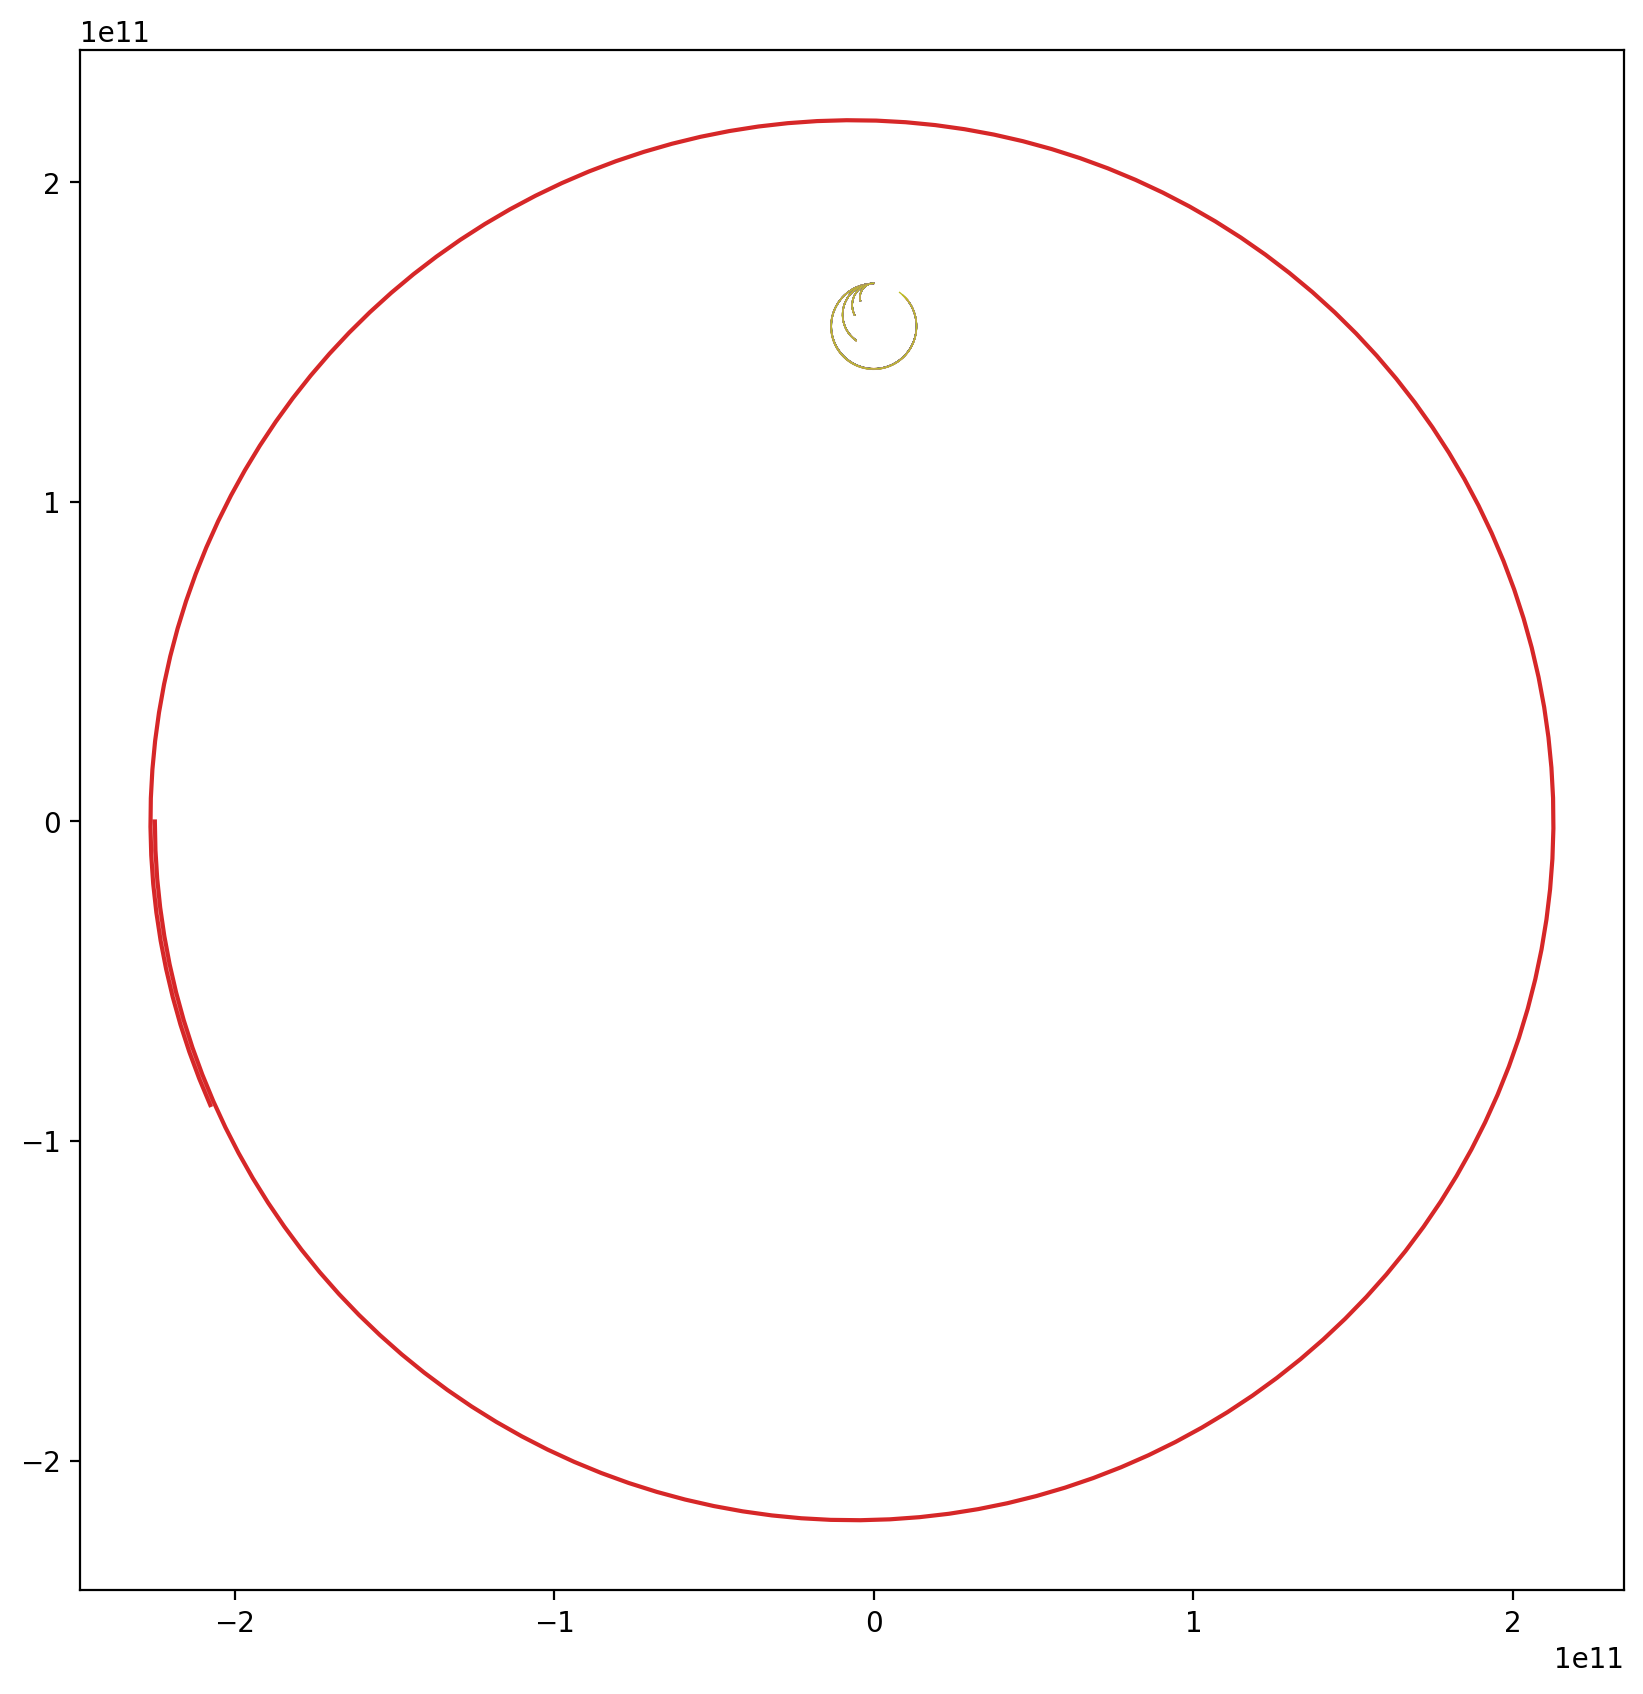

In [9]:
# Create the figure
plt.figure(figsize=(10,10), dpi=200)

# Draw in one path of Mars
M_rx = np.array(pd.read_csv(f'Mars_{orbit_times[0]}_{burn_angles[0]}_{burn_percentages[0]}.csv', delimiter =',', header=None))[1][0::250]
M_ry = np.array(pd.read_csv(f'Mars_{orbit_times[0]}_{burn_angles[0]}_{burn_percentages[0]}.csv', delimiter =',', header=None))[2][0::250]
plt.plot(M_rx, M_ry, color='tab:red')

# For each different variable, plot
for ot in range(len(orbit_times)):
    
    for p in range(len(burn_percentages)):
    
        for a in range(len(burn_angles)):
            
            colors = ['tab:orange','tab:blue','tab:green','tab:purple','tab:pink','tab:olive','tab:cyan', 'dodgerblue', 'darkcyan', 'lime', 'fuchsia', 'indigo']
            
            S_rx = np.array(pd.read_csv(f'Spaceship_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv', delimiter =',', header=None))[3][0::250]
            S_ry = np.array(pd.read_csv(f'Spaceship_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv', delimiter =',', header=None))[4][0::250]    
            
            plt.plot(S_ry, -S_rx+1.5e11, color=colors[a], lw=0.5)

plt.gca().set_aspect('equal')
plt.show()



The simulation here runs for 1.5 years. Something is wrong with the time dimension here because there is no way that a spaceship is taking that path over that long a time. Something got crossed in the code above. I talk a little about this below. 

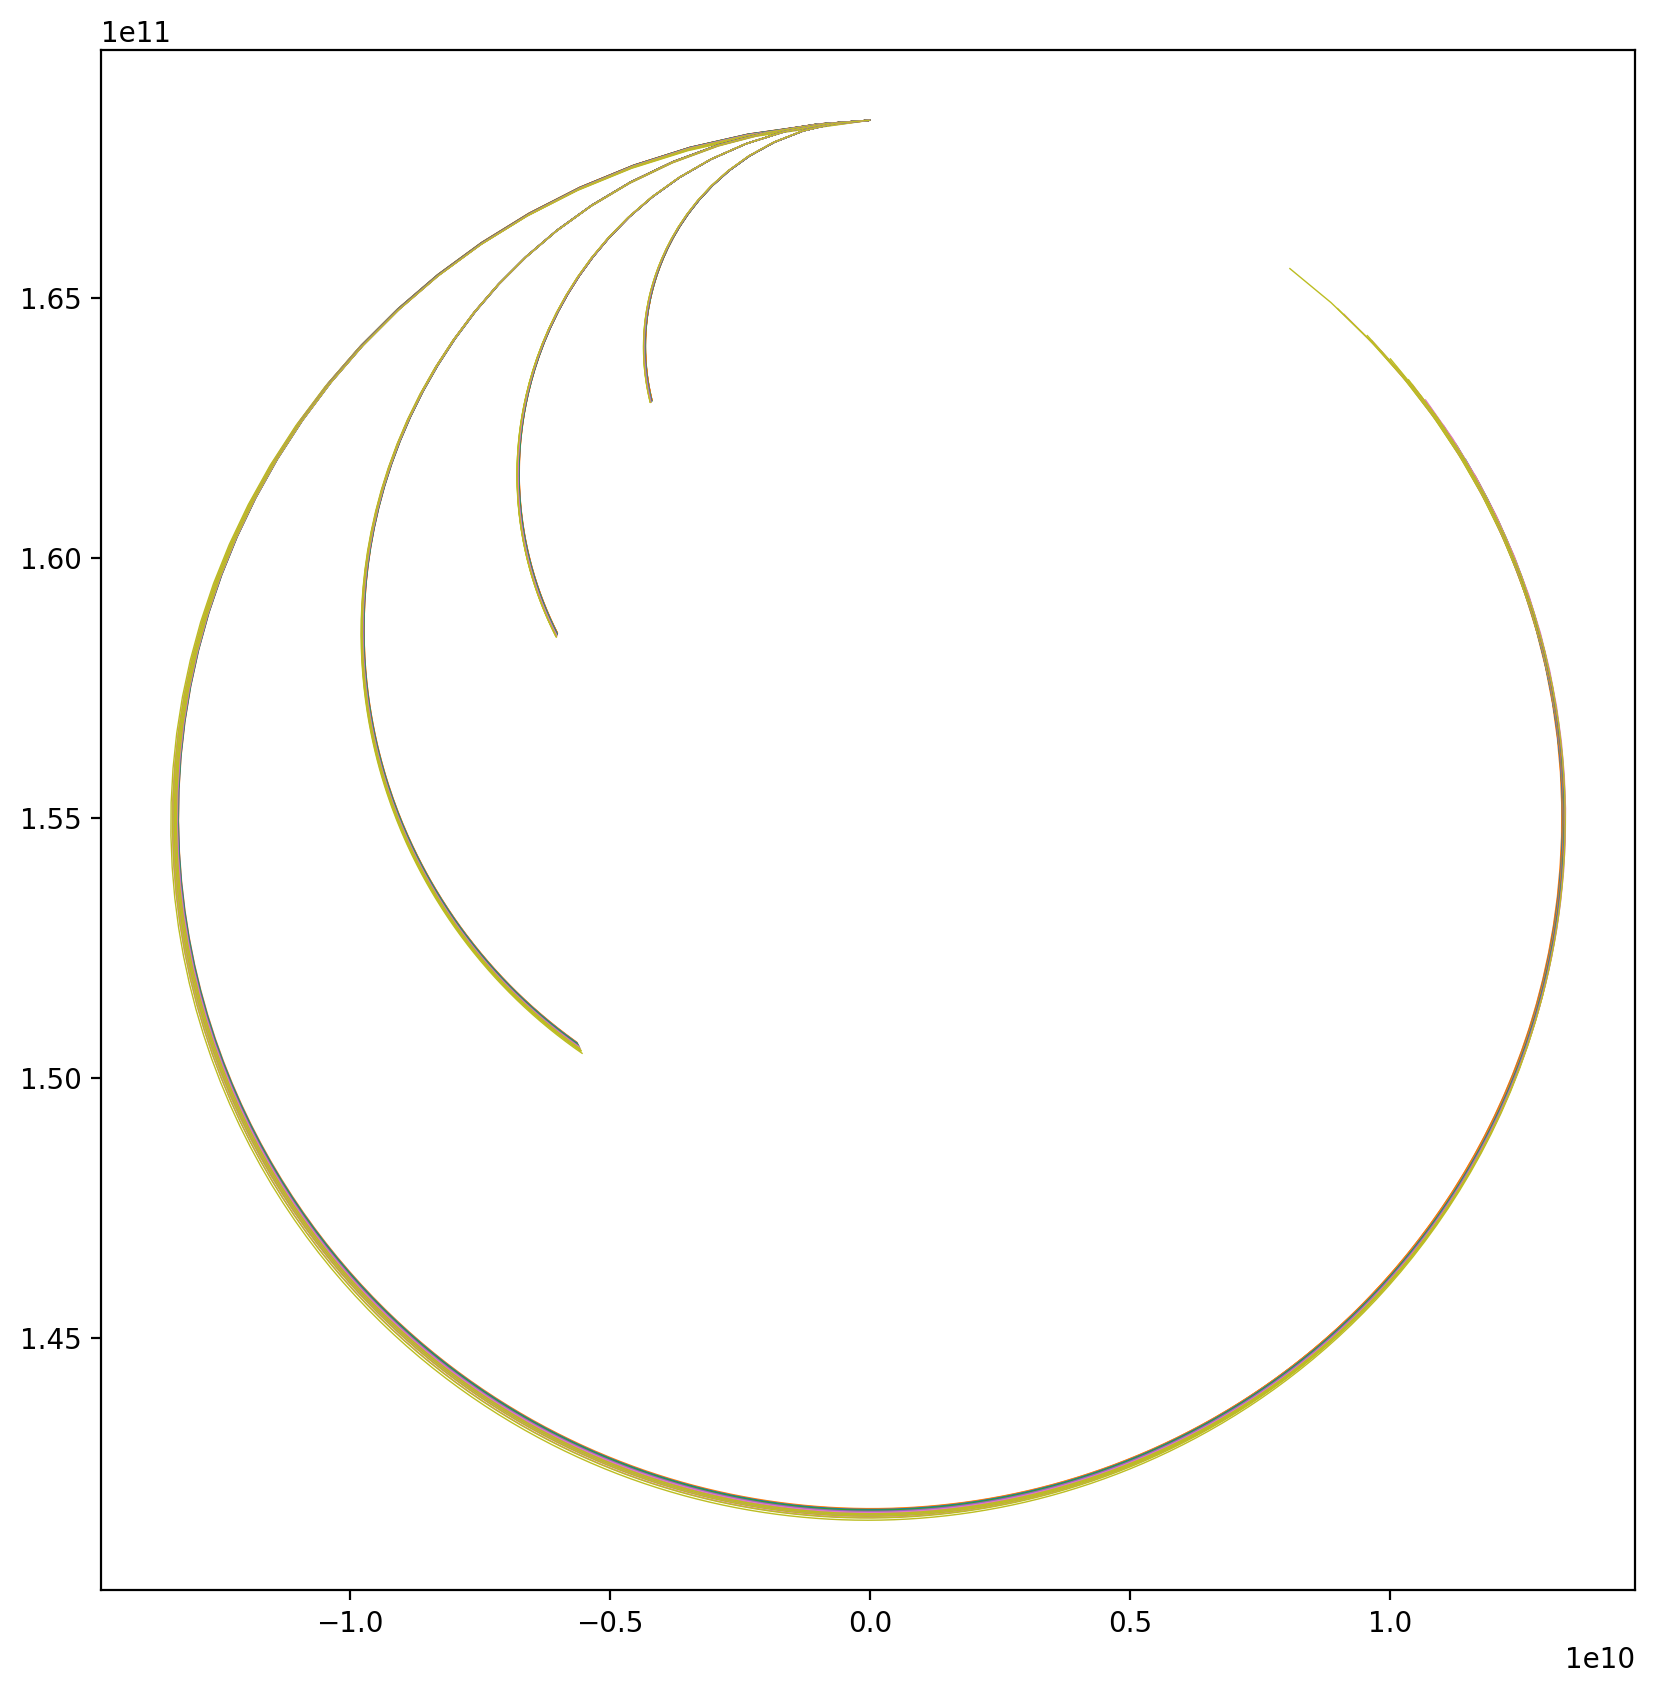

In [10]:
# Create the figure
plt.figure(figsize=(10,10), dpi=200)

# For each different variable, plot
for ot in range(len(orbit_times)):
    
    for p in range(len(burn_percentages)):
    
        for a in range(len(burn_angles)):
            
            colors = ['tab:orange','tab:blue','tab:green','tab:purple','tab:pink','tab:olive','tab:cyan', 'dodgerblue', 'darkcyan', 'lime', 'fuchsia', 'indigo']
            
            S_rx = np.array(pd.read_csv(f'Spaceship_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv', delimiter =',', header=None))[3][0::250]
            S_ry = np.array(pd.read_csv(f'Spaceship_{orbit_times[ot]}_{burn_angles[a]}_{burn_percentages[p]}.csv', delimiter =',', header=None))[4][0::250]
            
            plt.plot(S_ry, -S_rx+1.5e11, color=colors[a], lw=0.5)

plt.gca().set_aspect('equal')
plt.show()

The different colors above are all different burn angles, which indicates to me that something about the burn angle isn't implemented correctly. Perhaps it is an issue with passing burn instructions through the spaceship object? The paths should be much different.

The different branches are all belonging to the same family of how much fuel was actually burned. ex: 25%, 50%, 75% etc

I can sort of see where the paths are shifted around from where the burn was started late, but that is hard to see without a time axis. 

# What went right

1) Free space code performs as expected:
    - In the first section it is seen that shooting methods can be used to find a semi-stable orbit around Earth at a desired distance.
    - Total energy with no burning rockets stays constant which tells me that I have a stable system (at least over <5 year time scales).
2) I successfully used a different norm to select a more bound orbit
    - Opens up the possibility for using differing weight functions combined with norms to look for specific characteristics (eccentricity, bound then unbound, unbound then bound, etc). For example, if I wanted an eccentric orbit, I could weight possible paths where the craft is far from the planet differently than when it is close to the planet and that would incentivize the computer to pick a path that pass both close and far to the planet. 
3) I was able to save computed paths to my hard drive on .csv files. They take up lots of space (100mb per path if not compressed or spliced down). It also takes a long time to write them to my drive. I have to do this because I do not have enough ram otherwise. 

# What went wrong

1) The integrator I used does some weird stuff with time
    - I think that because I used an adaptive time-stepping algorithm that had VERY strict inout specifications I unintentionally broke something within the black box which caused some strange errors with the solver.
        - As I was troubleshooting, I found that it sometimes steps back in time, which really messed with how I was conserving mass in the rocket. I think that was a big confounding factor.
        - I was instructing the integrator to enforce a minimum step size even with adaptive methods to keep the runtime down, but it would ignore my parameters.
        - I think that the best way for me to fix this would be to write my own symplectic integrator that could solve these systems of first order ODES, but that was outside the scope of this project for me. 
2) As I was working before the presentation, I incorrectly implemented the rocket burning function because I missed the weird time stepping issues because I never plotted the values as a function of time, only looked at different XY positions like the plots above. As such, some values weren't well conserved and ended up with really lucky values that just happened to look correct.
3) It is possible that I made a semantical error somewhere above that doesn't have syntax errors and I just was not able to find it in time. 

# What I will do in the future

I've wanted to do work with astrodynamics since high school and taking this class was a way for me to improve my numerical skills on this type of code. This project was a sort of proof-of-concept for some ideas I've been thinking about for the past 4 years and I plan on finishing it over the summer and adding it to my portfolio. My rough plan is as follows:
1) Write a real symplectic integrator that works better with the classes that I made. I really want to get rid of the script that I use to write the code out for me. It is annoying.
2) I want to redefine by burn parameters and revisit the geometry there. 
3) I liked the solution I found for the norms and classifying different orbits. I want to add that to the code in a more general way. 

Thank you for reading through all this. I know that I did not finish everything that I wanted to in this project, but I hope that some of my thoughts and work show that I did try and fix the problems.